## Due to the file size limit on Github, we are unable to upload the full Portland dataset (>900MB) to this repository. Leave a comment on the Github page if you require the datasets ued in this notebook. 

In [1]:
using DelimitedFiles
using Random
using Statistics
using Printf
include("func.jl");
include("agentSEIR.jl");

In [2]:
using PyCall, PyPlot
plt = pyimport("matplotlib.pyplot");

# Read Data

In [3]:
contact_degree = Int[]
open("data/portland/portland_ContactDegree.txt") do io
    for s in eachline(io)
        push!(contact_degree, Int(parse(Float64,s)))
    end
end
contacts = Int[]
open("data/portland/portland_Contacts.txt") do io
    for s in eachline(io)
        push!(contacts, Int(parse(Float64,s)))
    end
end

n = length(contact_degree)
end_ = cumsum(contact_degree)
beg_ = vcat(0, end_[1:n-1])
beg_ .+= 1
ll = [contacts[i:j] for (i,j) in zip(beg_, end_)]

end_ = nothing
beg_ = nothing
contacts = nothing
GC.gc()

In [4]:
# Load pre-sorted edges according to LF betweenness
sorted_edges = readdlm("data/portland/portland_edgelist_sorted.txt", '\t', Int, '\n');
m = size(sorted_edges,1);

In [5]:
# Load pre-computed eigenvector centrality
eg = vec(readdlm("data/portland/portland_eigenvector_centrality.txt"));

# Intervention and simulation results

In [6]:
init_infectious = vec(readdlm("data/portland/portland_initial_cluster.txt", '\t', Int, '\n'));

In [7]:
edge_to_loc = Dict{Tuple{Int,Int},Int}()
for i in 1:length(ll)
    for (loc,j) in enumerate(ll[i])
        edge_to_loc[(i,j)] = loc
    end
end

## Scenario 1: $\beta$ is set to correspond to $R_0 = 2.5$

In [8]:
# Verify that beta is set appropriately
t_end = 100
_, sum_S, sum_E, sum_I, sum_R = Main.agentSEIR(ll, days=t_end, beta=0.06)
println("This should be around 0.89: ", sum_R[t_end+1]/n)

This should be around 0.89: 0.8918179792803832


In [9]:
perc = .25;
reduced_weight = .1;

In [10]:
lw_ui = [ones(length(arr)).*(1.0-(1.0-reduced_weight)*perc) for arr in ll];
lw_hd = get_list_of_weights_degree_dist(ll, edge_to_loc, perc, weight=reduced_weight);
lw_eg = get_list_of_weights_node_centrality(ll, eg, m, edge_to_loc, perc, weight=reduced_weight);
lw_lf = get_list_of_weights_sorted_edges(ll, sorted_edges, edge_to_loc, perc, weight=reduced_weight);

#### Predicted epidemic curves: random initialization, no delay, 25% intervention

In [11]:
t_end = 50

init_rand_infectious = rand(1:n, Int(ceil(0.001*n)))

_, sum_S_ni, sum_E_ni, sum_I_ni, sum_R_ni = agentSEIR(ll, days=t_end, beta=0.06, rand_init=false, init_infectious_nodes=init_rand_infectious);
_, sum_S_ui, sum_E_ui, sum_I_ui, sum_R_ui = agentSEIR(ll, days=t_end, beta=0.06, weighted=true, lw=lw_ui, rand_init=false, init_infectious_nodes=init_rand_infectious);
_, sum_S_hd, sum_E_hd, sum_I_hd, sum_R_hd = agentSEIR(ll, days=t_end, beta=0.06, weighted=true, lw=lw_hd, rand_init=false, init_infectious_nodes=init_rand_infectious);
_, sum_S_eg, sum_E_eg, sum_I_eg, sum_R_eg = agentSEIR(ll, days=t_end, beta=0.06, weighted=true, lw=lw_eg, rand_init=false, init_infectious_nodes=init_rand_infectious);
_, sum_S_lf, sum_E_lf, sum_I_lf, sum_R_lf = agentSEIR(ll, days=t_end, beta=0.06, weighted=true, lw=lw_lf, rand_init=false, init_infectious_nodes=init_rand_infectious);

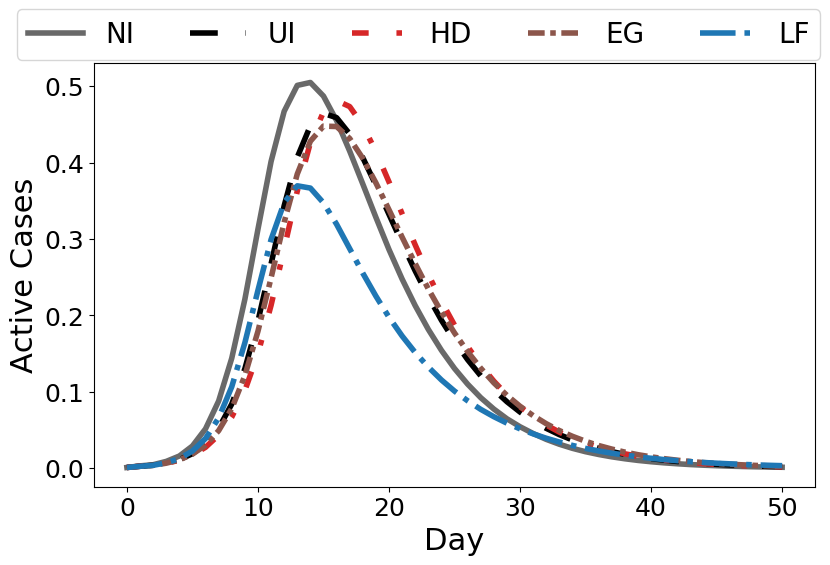

In [12]:
t_int = [i for i in 0:t_end]

plt.figure(figsize=(9.3,5.5))
plt.plot(t_int, (sum_E_ni+sum_I_ni)/n, label="NI", linestyle="-", color="dimgray", linewidth=4)
plt.plot(t_int, (sum_E_ui+sum_I_ui)/n, label="UI", linestyle=(0,(5,5)), color="k", linewidth=4)
plt.plot(t_int, (sum_E_hd+sum_I_hd)/n, label="HD", linestyle=(0,(3,5,1,5)), color="tab:red", linewidth=4, alpha=1)
plt.plot(t_int, (sum_E_eg+sum_I_eg)/n, label="EG", linestyle=(0,(3,1,1,1)), color="tab:brown", linewidth=4, alpha=1)
plt.plot(t_int, (sum_E_lf+sum_I_lf)/n, label="LF", linestyle="dashdot", color="tab:blue", linewidth=4, alpha=1)
leg = plt.legend(fontsize=20, bbox_to_anchor=(.45, 1.16), ncol=5, loc="upper center", handlelength=2)
for i in leg.legendHandles
    i.set_linewidth(4)
end
plt.xticks(size=18)
plt.yticks(size=18)
plt.xlabel("Day", fontsize=22)
plt.ylabel("Active Cases", fontsize=22)
plt.savefig("portland_curves_randinit_R025.png", bbox_inches="tight", format="png", dpi=400)
plt.show()

#### Predicted epidemic curves: random initialization, delay = 10 days, 25% intervention

In [13]:
t_end = 50
t_delay = 10
t_con = t_end - t_delay

init_state, sum_S, sum_E, sum_I, sum_R = Main.agentSEIR(ll, days=t_delay, beta=0.06);
_, _, sum_E_ni, sum_I_ni, sum_R_ni = Main.agentSEIR(ll, days=t_con, beta=0.06, rand_init=false, init_state=init_state);
_, _, sum_E_ui, sum_I_ui, sum_R_ui = Main.agentSEIR(ll, days=t_con, beta=0.06, weighted=true, lw=lw_ui, rand_init=false, init_state=init_state);
_, _, sum_E_hd, sum_I_hd, sum_R_hd = Main.agentSEIR(ll, days=t_con, beta=0.06, weighted=true, lw=lw_hd, rand_init=false, init_state=init_state);
_, _, sum_E_eg, sum_I_eg, sum_R_eg = Main.agentSEIR(ll, days=t_con, beta=0.06, weighted=true, lw=lw_eg, rand_init=false, init_state=init_state);
_, _, sum_E_lf, sum_I_lf, sum_R_lf = Main.agentSEIR(ll, days=t_con, beta=0.06, weighted=true, lw=lw_lf, rand_init=false, init_state=init_state);

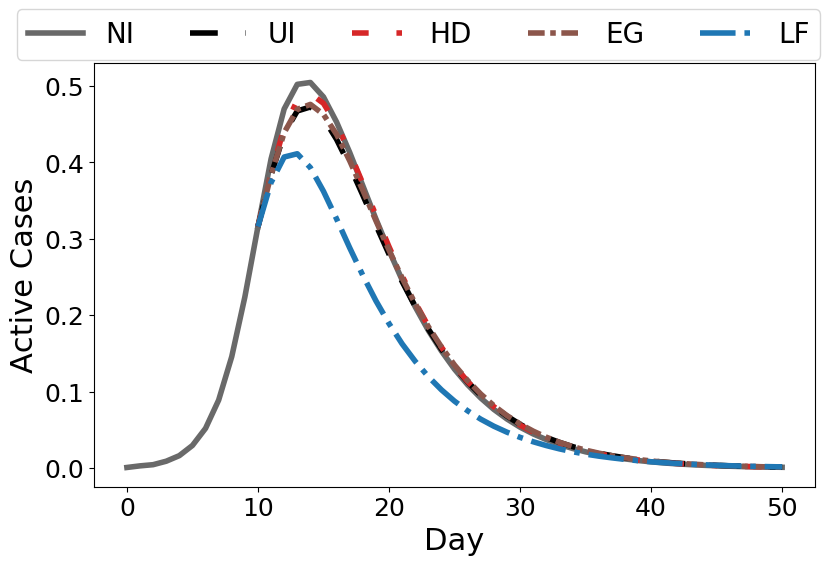

In [14]:
t_ini = [i for i in 0:t_delay]
t_int = [i for i in t_delay:t_end]

plt.figure(figsize=(9.3,5.5))
plt.plot(t_ini, (sum_E+sum_I)/n, linestyle="-", color="dimgray", linewidth=4)
plt.plot(t_int, (sum_E_ni+sum_I_ni)/n, label="NI", linestyle="-", color="dimgray", linewidth=4)
plt.plot(t_int, (sum_E_ui+sum_I_ui)/n, label="UI", linestyle=(0,(5,5)), color="k", linewidth=4)
plt.plot(t_int, (sum_E_hd+sum_I_hd)/n, label="HD", linestyle=(0,(3,5,1,5)), color="tab:red", linewidth=4, alpha=1)
plt.plot(t_int, (sum_E_eg+sum_I_eg)/n, label="EG", linestyle=(0,(3,1,1,1)), color="tab:brown", linewidth=4, alpha=1)
plt.plot(t_int, (sum_E_lf+sum_I_lf)/n, label="LF", linestyle="dashdot", color="tab:blue", linewidth=4, alpha=1)
leg = plt.legend(fontsize=20, bbox_to_anchor=(.45, 1.16), ncol=5, loc="upper center", handlelength=2)
for i in leg.legendHandles
    i.set_linewidth(4)
end
plt.xticks(size=18)
plt.yticks(size=18)
plt.xlabel("Day", fontsize=22)
plt.ylabel("Active Cases", fontsize=22)
plt.savefig("portland_curves_randinit_R025_delay10.png", bbox_inches="tight", format="png", dpi=400)
plt.show()

### Simulation for interventions that start on day 0

In [15]:
reduced_weight = .1;
t_end = 100;
target_perc = Float64[5.0e-2,.1,.15,.2,.25,.3,.35,.4,.45,.5];

num_scenarios = length(target_perc);
num_trials = 5;

maxCases_ni = zeros(Int, (num_trials,num_scenarios));
maxCases_ui = zeros(Int, (num_trials,num_scenarios));
maxCases_hd = zeros(Int, (num_trials,num_scenarios));
maxCases_eg = zeros(Int, (num_trials,num_scenarios));
maxCases_lf = zeros(Int, (num_trials,num_scenarios));
totalCases_ni = zeros(Int, (num_trials,num_scenarios));
totalCases_ui = zeros(Int, (num_trials,num_scenarios));
totalCases_hd = zeros(Int, (num_trials,num_scenarios));
totalCases_eg = zeros(Int, (num_trials,num_scenarios));
totalCases_lf = zeros(Int, (num_trials,num_scenarios));

for k in 1:num_scenarios
    
    perc = target_perc[k];
    
    lw_ui = [ones(length(arr)).*(1.0-(1.0-reduced_weight)*perc) for arr in ll];
    lw_hd = get_list_of_weights_degree_dist(ll, edge_to_loc, perc, weight=reduced_weight);
    lw_eg = get_list_of_weights_node_centrality(ll, eg, m, edge_to_loc, perc, weight=reduced_weight);
    lw_lf = get_list_of_weights_sorted_edges(ll, sorted_edges, edge_to_loc, perc, weight=reduced_weight);
    
    for trial in 1:num_trials
        
        @printf("\rperc %.2f \ttrial %d of %d ", perc, trial, num_trials)
        
        init_rand_infectious = rand(1:n, Int(ceil(0.001*n)))

        _, sum_S_ni, sum_E_ni, sum_I_ni, sum_R_ni = agentSEIR(ll, days=t_end, beta=0.06, rand_init=false, init_infectious_nodes=init_rand_infectious);
        _, sum_S_ui, sum_E_ui, sum_I_ui, sum_R_ui = agentSEIR(ll, days=t_end, beta=0.06, weighted=true, lw=lw_ui, rand_init=false, init_infectious_nodes=init_rand_infectious);
        _, sum_S_hd, sum_E_hd, sum_I_hd, sum_R_hd = agentSEIR(ll, days=t_end, beta=0.06, weighted=true, lw=lw_hd, rand_init=false, init_infectious_nodes=init_rand_infectious);
        _, sum_S_eg, sum_E_eg, sum_I_eg, sum_R_eg = agentSEIR(ll, days=t_end, beta=0.06, weighted=true, lw=lw_eg, rand_init=false, init_infectious_nodes=init_rand_infectious);
        _, sum_S_lf, sum_E_lf, sum_I_lf, sum_R_lf = agentSEIR(ll, days=t_end, beta=0.06, weighted=true, lw=lw_lf, rand_init=false, init_infectious_nodes=init_rand_infectious);
        
        maxCases_ni[trial,k] = maximum(sum_E_ni + sum_I_ni)
        maxCases_ui[trial,k] = maximum(sum_E_ui + sum_I_ui)
        maxCases_hd[trial,k] = maximum(sum_E_hd + sum_I_hd)
        maxCases_eg[trial,k] = maximum(sum_E_eg + sum_I_eg)
        maxCases_lf[trial,k] = maximum(sum_E_lf + sum_I_lf)   
        totalCases_ni[trial,k] = sum_R_ni[t_end+1]
        totalCases_ui[trial,k] = sum_R_ui[t_end+1]
        totalCases_hd[trial,k] = sum_R_hd[t_end+1]
        totalCases_eg[trial,k] = sum_R_eg[t_end+1]
        totalCases_lf[trial,k] = sum_R_lf[t_end+1]
    end
end

perc 0.50 	trial 5 of 5 0.15 	trial 2 of 5 0.15 	trial 4 of 5 0.20 	trial 1 of 5 0.20 	trial 2 of 5 0.20 	trial 3 of 5 0.20 	trial 4 of 5 0.20 	trial 5 of 5 0.25 	trial 1 of 5 0.25 	trial 3 of 5 0.25 	trial 5 of 5 0.35 	trial 2 of 5 0.35 	trial 4 of 5 0.40 	trial 1 of 5 0.40 	trial 2 of 5 0.40 	trial 3 of 5 0.40 	trial 4 of 5 0.40 	trial 5 of 5 0.45 	trial 1 of 5 0.45 	trial 3 of 5 0.45 	trial 5 of 5 

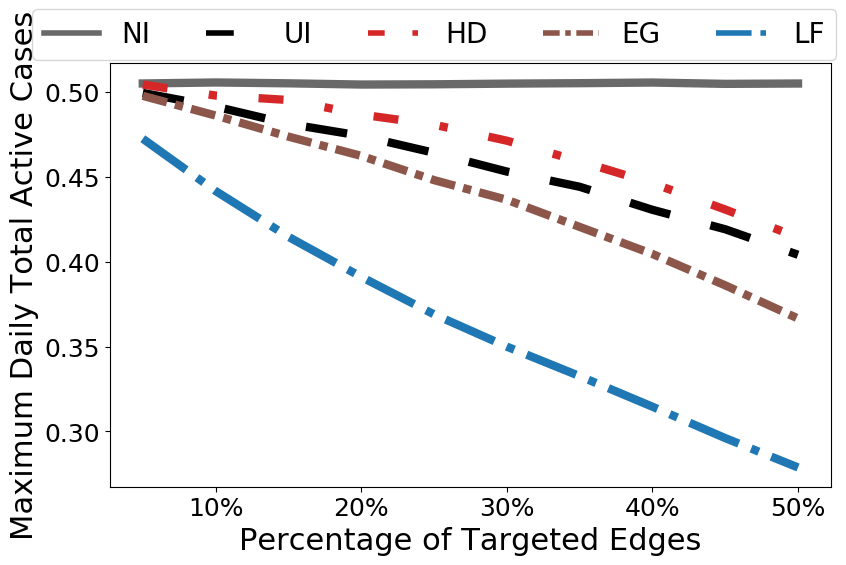

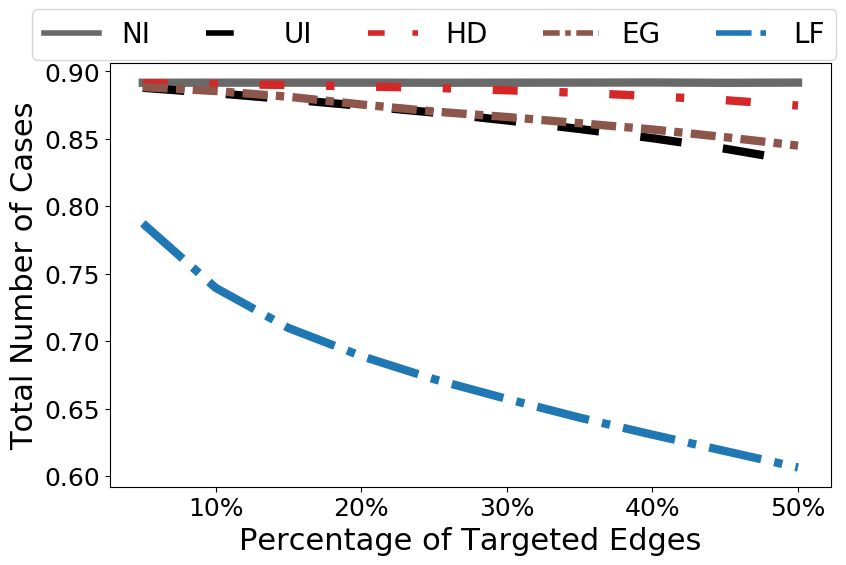

In [16]:
maxCases_ni_mean = vec(mean(maxCases_ni, dims=1))./n;
maxCases_ui_mean = vec(mean(maxCases_ui, dims=1))./n;
maxCases_hd_mean = vec(mean(maxCases_hd, dims=1))./n;
maxCases_eg_mean = vec(mean(maxCases_eg, dims=1))./n;
maxCases_lf_mean = vec(mean(maxCases_lf, dims=1))./n;
totalCases_ni_mean = vec(mean(totalCases_ni, dims=1))./n;
totalCases_ui_mean = vec(mean(totalCases_ui, dims=1))./n;
totalCases_hd_mean = vec(mean(totalCases_hd, dims=1))./n;
totalCases_eg_mean = vec(mean(totalCases_eg, dims=1))./n;
totalCases_lf_mean = vec(mean(totalCases_lf, dims=1))./n;

plt.figure(figsize=(9.3,5.5))
plt.plot(target_perc, maxCases_ni_mean, label="NI", linestyle="-", color="dimgray", linewidth=6)
plt.plot(target_perc, maxCases_ui_mean, label="UI", linestyle=(0,(5,5)), color="k", linewidth=6)
plt.plot(target_perc, maxCases_hd_mean, label="HD", linestyle=(0,(3,5,1,5)), color="tab:red", linewidth=6)
plt.plot(target_perc, maxCases_eg_mean, label="EG", linestyle=(0,(3,1,1,1)), color="tab:brown", linewidth=6)
plt.plot(target_perc, maxCases_lf_mean, label="LF", linestyle="dashdot", color="tab:blue", linewidth=6)
leg = plt.legend(fontsize=20, bbox_to_anchor=(.45, 1.16), ncol=5, loc="upper center", handlelength=2)
for i in leg.legendHandles
    i.set_linewidth(4)
end
plt.xticks((.1, .2, .3, .4, .5), ("10%", "20%", "30%", "40%", "50%"), color="k", size=18)
plt.yticks(size=18)
plt.xlabel("Percentage of Targeted Edges", fontsize=22)
plt.ylabel("Maximum Daily Total Active Cases",fontsize=22)
plt.savefig("portland_epipeak_randinit_R025.png", bbox_inches="tight", format="png", dpi=400)
plt.show()

plt.figure(figsize=(9.3,5.5))
plt.plot(target_perc, totalCases_ni_mean, label="NI", linestyle="-", color="dimgray", linewidth=6)
plt.plot(target_perc, totalCases_ui_mean, label="UI", linestyle=(0,(5,5)), color="k", linewidth=6)
plt.plot(target_perc, totalCases_hd_mean, label="HD", linestyle=(0,(3,5,1,5)), color="tab:red", linewidth=6)
plt.plot(target_perc, totalCases_eg_mean, label="EG", linestyle=(0,(3,1,1,1)), color="tab:brown", linewidth=6)
plt.plot(target_perc, totalCases_lf_mean, label="LF", linestyle="dashdot", color="tab:blue", linewidth=6)
leg = plt.legend(fontsize=20, bbox_to_anchor=(.45, 1.16), ncol=5, loc="upper center", handlelength=2)
for i in leg.legendHandles
    i.set_linewidth(4)
end
plt.xticks((.1, .2, .3, .4, .5), ("10%", "20%", "30%", "40%", "50%"), color="k", size=18)
plt.yticks(size=18)
plt.xlabel("Percentage of Targeted Edges", fontsize=22)
plt.ylabel("Total Number of Cases",fontsize=22)
plt.savefig("portland_episize_randinit_R025.png", bbox_inches="tight", format="png", dpi=400)
plt.show()

### Simulation for interventions that start on day 10

In [17]:
reduced_weight = .1;
target_perc = Float64[5.0e-2,.1,.15,.2,.25,.3,.35,.4,.45,.5];
t_end = 80
t_delay = 10
t_con = t_end - t_delay

num_scenarios = length(target_perc);
num_trials = 5;

maxCases_ni = zeros(Int, (num_trials,num_scenarios));
maxCases_ui = zeros(Int, (num_trials,num_scenarios));
maxCases_hd = zeros(Int, (num_trials,num_scenarios));
maxCases_eg = zeros(Int, (num_trials,num_scenarios));
maxCases_lf = zeros(Int, (num_trials,num_scenarios));
totalCases_ni = zeros(Int, (num_trials,num_scenarios));
totalCases_ui = zeros(Int, (num_trials,num_scenarios));
totalCases_hd = zeros(Int, (num_trials,num_scenarios));
totalCases_eg = zeros(Int, (num_trials,num_scenarios));
totalCases_lf = zeros(Int, (num_trials,num_scenarios));

for k in 1:num_scenarios
    
    perc = target_perc[k];
    
    lw_ui = [ones(length(arr)).*(1.0-(1.0-reduced_weight)*perc) for arr in ll];
    lw_hd = get_list_of_weights_degree_dist(ll, edge_to_loc, perc, weight=reduced_weight);
    lw_eg = get_list_of_weights_node_centrality(ll, eg, m, edge_to_loc, perc, weight=reduced_weight);
    lw_lf = get_list_of_weights_sorted_edges(ll, sorted_edges, edge_to_loc, perc, weight=reduced_weight);
    
    for trial in 1:num_trials
        
        @printf("\rperc %.2f \ttrial %d of %d ", perc, trial, num_trials)
        
        init_rand_infectious = rand(1:n, Int(ceil(0.001*n)))

        init_state, sum_S, sum_E, sum_I, sum_R = Main.agentSEIR(ll, days=t_delay, beta=0.06);
        _, _, sum_E_ni, sum_I_ni, sum_R_ni = Main.agentSEIR(ll, days=t_con, beta=0.06, rand_init=false, init_state=init_state);
        _, _, sum_E_ui, sum_I_ui, sum_R_ui = Main.agentSEIR(ll, days=t_con, beta=0.06, weighted=true, lw=lw_ui, rand_init=false, init_state=init_state);
        _, _, sum_E_hd, sum_I_hd, sum_R_hd = Main.agentSEIR(ll, days=t_con, beta=0.06, weighted=true, lw=lw_hd, rand_init=false, init_state=init_state);
        _, _, sum_E_eg, sum_I_eg, sum_R_eg = Main.agentSEIR(ll, days=t_con, beta=0.06, weighted=true, lw=lw_eg, rand_init=false, init_state=init_state);
        _, _, sum_E_lf, sum_I_lf, sum_R_lf = Main.agentSEIR(ll, days=t_con, beta=0.06, weighted=true, lw=lw_lf, rand_init=false, init_state=init_state);
        
        maxCases_ni[trial,k] = maximum(sum_E_ni + sum_I_ni)
        maxCases_ui[trial,k] = maximum(sum_E_ui + sum_I_ui)
        maxCases_hd[trial,k] = maximum(sum_E_hd + sum_I_hd)
        maxCases_eg[trial,k] = maximum(sum_E_eg + sum_I_eg)
        maxCases_lf[trial,k] = maximum(sum_E_lf + sum_I_lf)   
        totalCases_ni[trial,k] = sum_R_ni[t_con+1]
        totalCases_ui[trial,k] = sum_R_ui[t_con+1]
        totalCases_hd[trial,k] = sum_R_hd[t_con+1]
        totalCases_eg[trial,k] = sum_R_eg[t_con+1]
        totalCases_lf[trial,k] = sum_R_lf[t_con+1]
    end
end

perc 0.50 	trial 5 of 5 0.15 	trial 2 of 5 0.15 	trial 4 of 5 0.20 	trial 1 of 5 0.20 	trial 2 of 5 0.20 	trial 3 of 5 0.20 	trial 4 of 5 0.20 	trial 5 of 5 0.25 	trial 1 of 5 0.25 	trial 3 of 5 0.25 	trial 5 of 5 0.35 	trial 2 of 5 0.35 	trial 4 of 5 0.40 	trial 1 of 5 0.40 	trial 2 of 5 0.40 	trial 3 of 5 0.40 	trial 4 of 5 0.40 	trial 5 of 5 0.45 	trial 1 of 5 0.45 	trial 3 of 5 0.45 	trial 5 of 5 

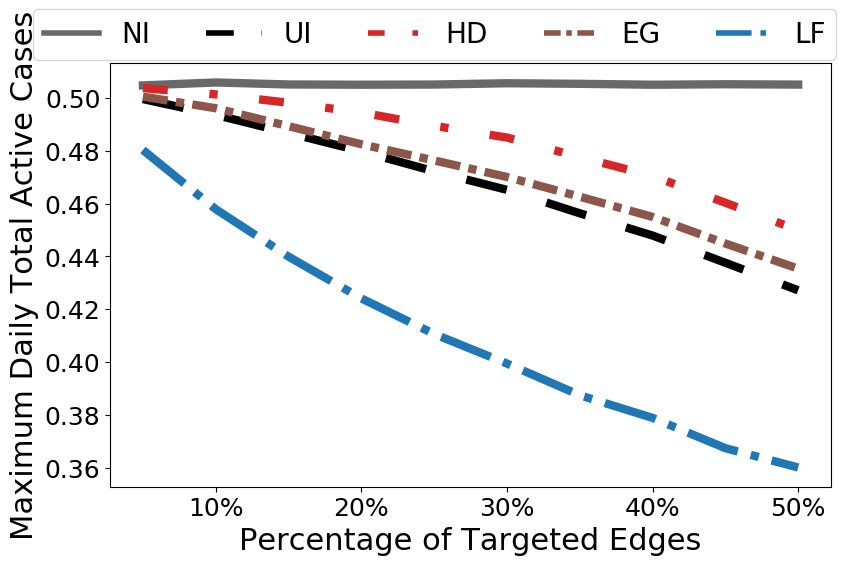

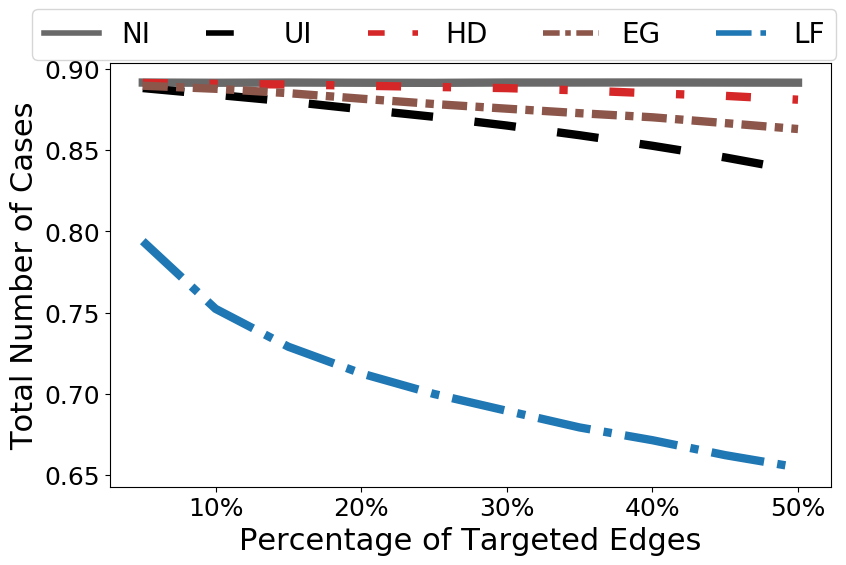

In [18]:
maxCases_ni_mean = vec(mean(maxCases_ni, dims=1))./n;
maxCases_ui_mean = vec(mean(maxCases_ui, dims=1))./n;
maxCases_hd_mean = vec(mean(maxCases_hd, dims=1))./n;
maxCases_eg_mean = vec(mean(maxCases_eg, dims=1))./n;
maxCases_lf_mean = vec(mean(maxCases_lf, dims=1))./n;
totalCases_ni_mean = vec(mean(totalCases_ni, dims=1))./n;
totalCases_ui_mean = vec(mean(totalCases_ui, dims=1))./n;
totalCases_hd_mean = vec(mean(totalCases_hd, dims=1))./n;
totalCases_eg_mean = vec(mean(totalCases_eg, dims=1))./n;
totalCases_lf_mean = vec(mean(totalCases_lf, dims=1))./n;

plt.figure(figsize=(9.3,5.5))
plt.plot(target_perc, maxCases_ni_mean, label="NI", linestyle="-", color="dimgray", linewidth=6)
plt.plot(target_perc, maxCases_ui_mean, label="UI", linestyle=(0,(5,5)), color="k", linewidth=6)
plt.plot(target_perc, maxCases_hd_mean, label="HD", linestyle=(0,(3,5,1,5)), color="tab:red", linewidth=6)
plt.plot(target_perc, maxCases_eg_mean, label="EG", linestyle=(0,(3,1,1,1)), color="tab:brown", linewidth=6)
plt.plot(target_perc, maxCases_lf_mean, label="LF", linestyle="dashdot", color="tab:blue", linewidth=6)
leg = plt.legend(fontsize=20, bbox_to_anchor=(.45, 1.16), ncol=5, loc="upper center", handlelength=2)
for i in leg.legendHandles
    i.set_linewidth(4)
end
plt.xticks((.1, .2, .3, .4, .5), ("10%", "20%", "30%", "40%", "50%"), color="k", size=18)
plt.yticks(size=18)
plt.xlabel("Percentage of Targeted Edges", fontsize=22)
plt.ylabel("Maximum Daily Total Active Cases",fontsize=22)
plt.savefig("portland_epipeak_randinit_R025_delay10.png", bbox_inches="tight", format="png", dpi=400)
plt.show()

plt.figure(figsize=(9.3,5.5))
plt.plot(target_perc, totalCases_ni_mean, label="NI", linestyle="-", color="dimgray", linewidth=6)
plt.plot(target_perc, totalCases_ui_mean, label="UI", linestyle=(0,(5,5)), color="k", linewidth=6)
plt.plot(target_perc, totalCases_hd_mean, label="HD", linestyle=(0,(3,5,1,5)), color="tab:red", linewidth=6)
plt.plot(target_perc, totalCases_eg_mean, label="EG", linestyle=(0,(3,1,1,1)), color="tab:brown", linewidth=6)
plt.plot(target_perc, totalCases_lf_mean, label="LF", linestyle="dashdot", color="tab:blue", linewidth=6)
leg = plt.legend(fontsize=20, bbox_to_anchor=(.45, 1.16), ncol=5, loc="upper center", handlelength=2)
for i in leg.legendHandles
    i.set_linewidth(4)
end
plt.xticks((.1, .2, .3, .4, .5), ("10%", "20%", "30%", "40%", "50%"), color="k", size=18)
plt.yticks(size=18)
plt.xlabel("Percentage of Targeted Edges", fontsize=22)
plt.ylabel("Total Number of Cases",fontsize=22)
plt.savefig("portland_episize_randinit_R025_delay10.png", bbox_inches="tight", format="png", dpi=400)
plt.show()

## Scenario 2: $\beta$ is set to correspond to $R_0 = 1.5$

In [19]:
# Verify that beta is set appropriately
t_end = 100
_, sum_S, sum_E, sum_I, sum_R = Main.agentSEIR(ll, days=t_end, beta=0.01)
println("This should be around 0.59: ", sum_R[t_end+1]/n)

This should be around 0.59: 0.5923885732674861


In [20]:
perc = .25;
reduced_weight = .1;

In [21]:
lw_ui = [ones(length(arr)).*(1.0-(1.0-reduced_weight)*perc) for arr in ll];
lw_hd = get_list_of_weights_degree_dist(ll, edge_to_loc, perc, weight=reduced_weight);
lw_eg = get_list_of_weights_node_centrality(ll, eg, m, edge_to_loc, perc, weight=reduced_weight);
lw_lf = get_list_of_weights_sorted_edges(ll, sorted_edges, edge_to_loc, perc, weight=reduced_weight);

#### Predicted epidemic curves: random initialization, no delay, 25% intervention

In [22]:
t_end = 100

init_rand_infectious = rand(1:n, Int(ceil(0.001*n)))

_, sum_S_ni, sum_E_ni, sum_I_ni, sum_R_ni = agentSEIR(ll, days=t_end, beta=0.01, rand_init=false, init_infectious_nodes=init_rand_infectious);
_, sum_S_ui, sum_E_ui, sum_I_ui, sum_R_ui = agentSEIR(ll, days=t_end, beta=0.01, weighted=true, lw=lw_ui, rand_init=false, init_infectious_nodes=init_rand_infectious);
_, sum_S_hd, sum_E_hd, sum_I_hd, sum_R_hd = agentSEIR(ll, days=t_end, beta=0.01, weighted=true, lw=lw_hd, rand_init=false, init_infectious_nodes=init_rand_infectious);
_, sum_S_eg, sum_E_eg, sum_I_eg, sum_R_eg = agentSEIR(ll, days=t_end, beta=0.01, weighted=true, lw=lw_eg, rand_init=false, init_infectious_nodes=init_rand_infectious);
_, sum_S_lf, sum_E_lf, sum_I_lf, sum_R_lf = agentSEIR(ll, days=t_end, beta=0.01, weighted=true, lw=lw_lf, rand_init=false, init_infectious_nodes=init_rand_infectious);

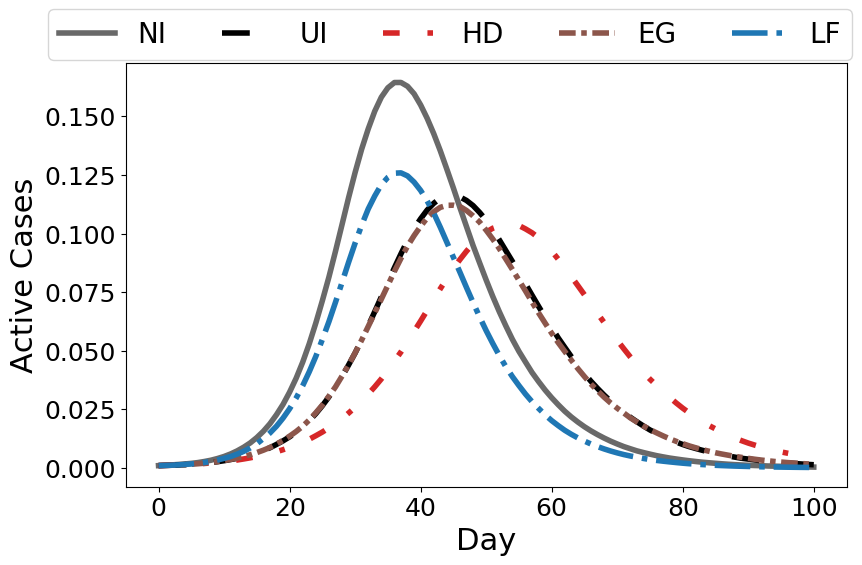

In [23]:
t_int = [i for i in 0:t_end]

plt.figure(figsize=(9.3,5.5))
plt.plot(t_int, (sum_E_ni+sum_I_ni)/n, label="NI", linestyle="-", color="dimgray", linewidth=4)
plt.plot(t_int, (sum_E_ui+sum_I_ui)/n, label="UI", linestyle=(0,(5,5)), color="k", linewidth=4)
plt.plot(t_int, (sum_E_hd+sum_I_hd)/n, label="HD", linestyle=(0,(3,5,1,5)), color="tab:red", linewidth=4, alpha=1)
plt.plot(t_int, (sum_E_eg+sum_I_eg)/n, label="EG", linestyle=(0,(3,1,1,1)), color="tab:brown", linewidth=4, alpha=1)
plt.plot(t_int, (sum_E_lf+sum_I_lf)/n, label="LF", linestyle="dashdot", color="tab:blue", linewidth=4, alpha=1)
leg = plt.legend(fontsize=20, bbox_to_anchor=(.45, 1.16), ncol=5, loc="upper center", handlelength=2)
for i in leg.legendHandles
    i.set_linewidth(4)
end
plt.xticks(size=18)
plt.yticks(size=18)
plt.xlabel("Day", fontsize=22)
plt.ylabel("Active Cases", fontsize=22)
plt.savefig("portland_curves_randinit_R015.png", bbox_inches="tight", format="png", dpi=400)
plt.show()

#### Predicted epidemic curves: random initialization, delay = 10 days, 25% intervention

In [24]:
t_end = 100
t_delay = 10
t_con = t_end - t_delay

init_state, sum_S, sum_E, sum_I, sum_R = Main.agentSEIR(ll, days=t_delay, beta=0.01);
_, _, sum_E_ni, sum_I_ni, sum_R_ni = Main.agentSEIR(ll, days=t_con, beta=0.01, rand_init=false, init_state=init_state);
_, _, sum_E_ui, sum_I_ui, sum_R_ui = Main.agentSEIR(ll, days=t_con, beta=0.01, weighted=true, lw=lw_ui, rand_init=false, init_state=init_state);
_, _, sum_E_hd, sum_I_hd, sum_R_hd = Main.agentSEIR(ll, days=t_con, beta=0.01, weighted=true, lw=lw_hd, rand_init=false, init_state=init_state);
_, _, sum_E_eg, sum_I_eg, sum_R_eg = Main.agentSEIR(ll, days=t_con, beta=0.01, weighted=true, lw=lw_eg, rand_init=false, init_state=init_state);
_, _, sum_E_lf, sum_I_lf, sum_R_lf = Main.agentSEIR(ll, days=t_con, beta=0.01, weighted=true, lw=lw_lf, rand_init=false, init_state=init_state);

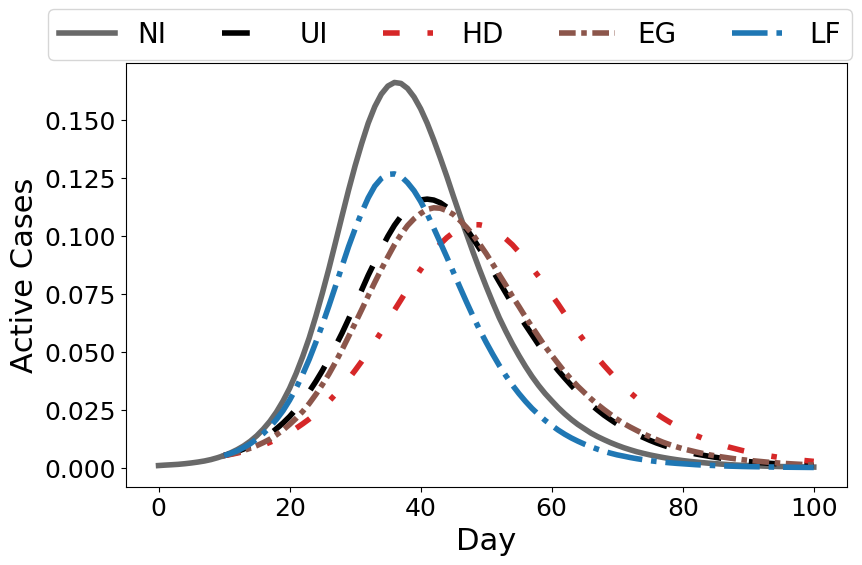

In [25]:
t_ini = [i for i in 0:t_delay]
t_int = [i for i in t_delay:t_end]

plt.figure(figsize=(9.3,5.5))
plt.plot(t_ini, (sum_E+sum_I)/n, linestyle="-", color="dimgray", linewidth=4)
plt.plot(t_int, (sum_E_ni+sum_I_ni)/n, label="NI", linestyle="-", color="dimgray", linewidth=4)
plt.plot(t_int, (sum_E_ui+sum_I_ui)/n, label="UI", linestyle=(0,(5,5)), color="k", linewidth=4)
plt.plot(t_int, (sum_E_hd+sum_I_hd)/n, label="HD", linestyle=(0,(3,5,1,5)), color="tab:red", linewidth=4, alpha=1)
plt.plot(t_int, (sum_E_eg+sum_I_eg)/n, label="EG", linestyle=(0,(3,1,1,1)), color="tab:brown", linewidth=4, alpha=1)
plt.plot(t_int, (sum_E_lf+sum_I_lf)/n, label="LF", linestyle="dashdot", color="tab:blue", linewidth=4, alpha=1)
leg = plt.legend(fontsize=20, bbox_to_anchor=(.45, 1.16), ncol=5, loc="upper center", handlelength=2)
for i in leg.legendHandles
    i.set_linewidth(4)
end
plt.xticks(size=18)
plt.yticks(size=18)
plt.xlabel("Day", fontsize=22)
plt.ylabel("Active Cases", fontsize=22)
plt.savefig("portland_curves_randinit_R015_delay10.png", bbox_inches="tight", format="png", dpi=400)
plt.show()

### Simulation for interventions that start on day 0

In [26]:
reduced_weight = .1;
t_end = 200;
target_perc = Float64[5.0e-2,.1,.15,.2,.25,.3,.35,.4,.45,.5];

num_scenarios = length(target_perc);
num_trials = 5;

maxCases_ni = zeros(Int, (num_trials,num_scenarios));
maxCases_ui = zeros(Int, (num_trials,num_scenarios));
maxCases_hd = zeros(Int, (num_trials,num_scenarios));
maxCases_eg = zeros(Int, (num_trials,num_scenarios));
maxCases_lf = zeros(Int, (num_trials,num_scenarios));
totalCases_ni = zeros(Int, (num_trials,num_scenarios));
totalCases_ui = zeros(Int, (num_trials,num_scenarios));
totalCases_hd = zeros(Int, (num_trials,num_scenarios));
totalCases_eg = zeros(Int, (num_trials,num_scenarios));
totalCases_lf = zeros(Int, (num_trials,num_scenarios));

for k in 1:num_scenarios
    
    perc = target_perc[k];
    
    lw_ui = [ones(length(arr)).*(1.0-(1.0-reduced_weight)*perc) for arr in ll];
    lw_hd = get_list_of_weights_degree_dist(ll, edge_to_loc, perc, weight=reduced_weight);
    lw_eg = get_list_of_weights_node_centrality(ll, eg, m, edge_to_loc, perc, weight=reduced_weight);
    lw_lf = get_list_of_weights_sorted_edges(ll, sorted_edges, edge_to_loc, perc, weight=reduced_weight);
    
    for trial in 1:num_trials
        
        @printf("\rperc %.2f \ttrial %d of %d ", perc, trial, num_trials)
        
        init_rand_infectious = rand(1:n, Int(ceil(0.001*n)))

        _, sum_S_ni, sum_E_ni, sum_I_ni, sum_R_ni = agentSEIR(ll, days=t_end, beta=0.01, rand_init=false, init_infectious_nodes=init_rand_infectious);
        _, sum_S_ui, sum_E_ui, sum_I_ui, sum_R_ui = agentSEIR(ll, days=t_end, beta=0.01, weighted=true, lw=lw_ui, rand_init=false, init_infectious_nodes=init_rand_infectious);
        _, sum_S_hd, sum_E_hd, sum_I_hd, sum_R_hd = agentSEIR(ll, days=t_end, beta=0.01, weighted=true, lw=lw_hd, rand_init=false, init_infectious_nodes=init_rand_infectious);
        _, sum_S_eg, sum_E_eg, sum_I_eg, sum_R_eg = agentSEIR(ll, days=t_end, beta=0.01, weighted=true, lw=lw_eg, rand_init=false, init_infectious_nodes=init_rand_infectious);
        _, sum_S_lf, sum_E_lf, sum_I_lf, sum_R_lf = agentSEIR(ll, days=t_end, beta=0.01, weighted=true, lw=lw_lf, rand_init=false, init_infectious_nodes=init_rand_infectious);
        
        maxCases_ni[trial,k] = maximum(sum_E_ni + sum_I_ni)
        maxCases_ui[trial,k] = maximum(sum_E_ui + sum_I_ui)
        maxCases_hd[trial,k] = maximum(sum_E_hd + sum_I_hd)
        maxCases_eg[trial,k] = maximum(sum_E_eg + sum_I_eg)
        maxCases_lf[trial,k] = maximum(sum_E_lf + sum_I_lf)   
        totalCases_ni[trial,k] = sum_R_ni[t_end+1]
        totalCases_ui[trial,k] = sum_R_ui[t_end+1]
        totalCases_hd[trial,k] = sum_R_hd[t_end+1]
        totalCases_eg[trial,k] = sum_R_eg[t_end+1]
        totalCases_lf[trial,k] = sum_R_lf[t_end+1]
    end
end

perc 0.50 	trial 5 of 5 0.15 	trial 2 of 5 0.15 	trial 4 of 5 0.20 	trial 1 of 5 0.20 	trial 2 of 5 0.20 	trial 3 of 5 0.20 	trial 4 of 5 0.20 	trial 5 of 5 0.25 	trial 1 of 5 0.25 	trial 3 of 5 0.25 	trial 5 of 5 0.35 	trial 2 of 5 0.35 	trial 4 of 5 0.40 	trial 1 of 5 0.40 	trial 2 of 5 0.40 	trial 3 of 5 0.40 	trial 4 of 5 0.40 	trial 5 of 5 0.45 	trial 1 of 5 0.45 	trial 3 of 5 0.45 	trial 5 of 5 

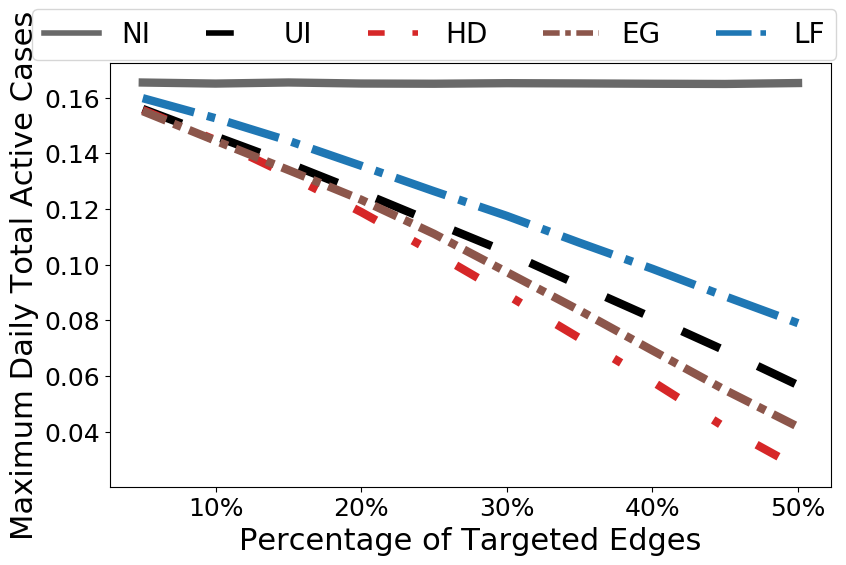

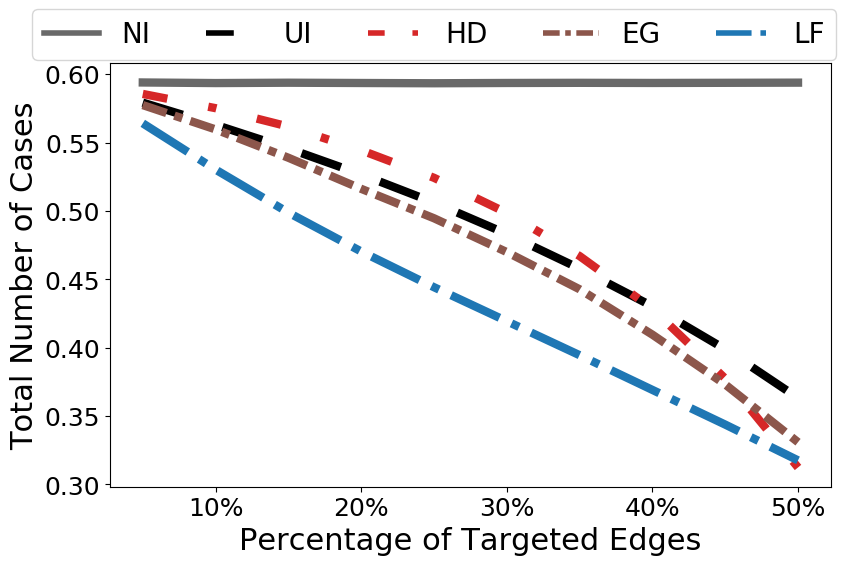

In [27]:
maxCases_ni_mean = vec(mean(maxCases_ni, dims=1))./n;
maxCases_ui_mean = vec(mean(maxCases_ui, dims=1))./n;
maxCases_hd_mean = vec(mean(maxCases_hd, dims=1))./n;
maxCases_eg_mean = vec(mean(maxCases_eg, dims=1))./n;
maxCases_lf_mean = vec(mean(maxCases_lf, dims=1))./n;
totalCases_ni_mean = vec(mean(totalCases_ni, dims=1))./n;
totalCases_ui_mean = vec(mean(totalCases_ui, dims=1))./n;
totalCases_hd_mean = vec(mean(totalCases_hd, dims=1))./n;
totalCases_eg_mean = vec(mean(totalCases_eg, dims=1))./n;
totalCases_lf_mean = vec(mean(totalCases_lf, dims=1))./n;

plt.figure(figsize=(9.3,5.5))
plt.plot(target_perc, maxCases_ni_mean, label="NI", linestyle="-", color="dimgray", linewidth=6)
plt.plot(target_perc, maxCases_ui_mean, label="UI", linestyle=(0,(5,5)), color="k", linewidth=6)
plt.plot(target_perc, maxCases_hd_mean, label="HD", linestyle=(0,(3,5,1,5)), color="tab:red", linewidth=6)
plt.plot(target_perc, maxCases_eg_mean, label="EG", linestyle=(0,(3,1,1,1)), color="tab:brown", linewidth=6)
plt.plot(target_perc, maxCases_lf_mean, label="LF", linestyle="dashdot", color="tab:blue", linewidth=6)
leg = plt.legend(fontsize=20, bbox_to_anchor=(.45, 1.16), ncol=5, loc="upper center", handlelength=2)
for i in leg.legendHandles
    i.set_linewidth(4)
end
plt.xticks((.1, .2, .3, .4, .5), ("10%", "20%", "30%", "40%", "50%"), color="k", size=18)
plt.yticks(size=18)
plt.xlabel("Percentage of Targeted Edges", fontsize=22)
plt.ylabel("Maximum Daily Total Active Cases",fontsize=22)
plt.savefig("portland_epipeak_randinit_R015.png", bbox_inches="tight", format="png", dpi=400)
plt.show()

plt.figure(figsize=(9.3,5.5))
plt.plot(target_perc, totalCases_ni_mean, label="NI", linestyle="-", color="dimgray", linewidth=6)
plt.plot(target_perc, totalCases_ui_mean, label="UI", linestyle=(0,(5,5)), color="k", linewidth=6)
plt.plot(target_perc, totalCases_hd_mean, label="HD", linestyle=(0,(3,5,1,5)), color="tab:red", linewidth=6)
plt.plot(target_perc, totalCases_eg_mean, label="EG", linestyle=(0,(3,1,1,1)), color="tab:brown", linewidth=6)
plt.plot(target_perc, totalCases_lf_mean, label="LF", linestyle="dashdot", color="tab:blue", linewidth=6)
leg = plt.legend(fontsize=20, bbox_to_anchor=(.45, 1.16), ncol=5, loc="upper center", handlelength=2)
for i in leg.legendHandles
    i.set_linewidth(4)
end
plt.xticks((.1, .2, .3, .4, .5), ("10%", "20%", "30%", "40%", "50%"), color="k", size=18)
plt.yticks(size=18)
plt.xlabel("Percentage of Targeted Edges", fontsize=22)
plt.ylabel("Total Number of Cases",fontsize=22)
plt.savefig("portland_episize_randinit_R015.png", bbox_inches="tight", format="png", dpi=400)
plt.show()

### Simulation for interventions that start on day 10

In [28]:
reduced_weight = .1;
target_perc = Float64[5.0e-2,.1,.15,.2,.25,.3,.35,.4,.45,.5];
t_end = 200
t_delay = 10
t_con = t_end - t_delay

num_scenarios = length(target_perc);
num_trials = 5;

maxCases_ni = zeros(Int, (num_trials,num_scenarios));
maxCases_ui = zeros(Int, (num_trials,num_scenarios));
maxCases_hd = zeros(Int, (num_trials,num_scenarios));
maxCases_eg = zeros(Int, (num_trials,num_scenarios));
maxCases_lf = zeros(Int, (num_trials,num_scenarios));
totalCases_ni = zeros(Int, (num_trials,num_scenarios));
totalCases_ui = zeros(Int, (num_trials,num_scenarios));
totalCases_hd = zeros(Int, (num_trials,num_scenarios));
totalCases_eg = zeros(Int, (num_trials,num_scenarios));
totalCases_lf = zeros(Int, (num_trials,num_scenarios));

for k in 1:num_scenarios
    
    perc = target_perc[k];
    
    lw_ui = [ones(length(arr)).*(1.0-(1.0-reduced_weight)*perc) for arr in ll];
    lw_hd = get_list_of_weights_degree_dist(ll, edge_to_loc, perc, weight=reduced_weight);
    lw_eg = get_list_of_weights_node_centrality(ll, eg, m, edge_to_loc, perc, weight=reduced_weight);
    lw_lf = get_list_of_weights_sorted_edges(ll, sorted_edges, edge_to_loc, perc, weight=reduced_weight);
    
    for trial in 1:num_trials
        
        @printf("\rperc %.2f \ttrial %d of %d ", perc, trial, num_trials)
        
        init_rand_infectious = rand(1:n, Int(ceil(0.001*n)))

        init_state, sum_S, sum_E, sum_I, sum_R = Main.agentSEIR(ll, days=t_delay, beta=0.01);
        _, _, sum_E_ni, sum_I_ni, sum_R_ni = Main.agentSEIR(ll, days=t_con, beta=0.01, rand_init=false, init_state=init_state);
        _, _, sum_E_ui, sum_I_ui, sum_R_ui = Main.agentSEIR(ll, days=t_con, beta=0.01, weighted=true, lw=lw_ui, rand_init=false, init_state=init_state);
        _, _, sum_E_hd, sum_I_hd, sum_R_hd = Main.agentSEIR(ll, days=t_con, beta=0.01, weighted=true, lw=lw_hd, rand_init=false, init_state=init_state);
        _, _, sum_E_eg, sum_I_eg, sum_R_eg = Main.agentSEIR(ll, days=t_con, beta=0.01, weighted=true, lw=lw_eg, rand_init=false, init_state=init_state);
        _, _, sum_E_lf, sum_I_lf, sum_R_lf = Main.agentSEIR(ll, days=t_con, beta=0.01, weighted=true, lw=lw_lf, rand_init=false, init_state=init_state);
        
        maxCases_ni[trial,k] = maximum(sum_E_ni + sum_I_ni)
        maxCases_ui[trial,k] = maximum(sum_E_ui + sum_I_ui)
        maxCases_hd[trial,k] = maximum(sum_E_hd + sum_I_hd)
        maxCases_eg[trial,k] = maximum(sum_E_eg + sum_I_eg)
        maxCases_lf[trial,k] = maximum(sum_E_lf + sum_I_lf)   
        totalCases_ni[trial,k] = sum_R_ni[t_con+1]
        totalCases_ui[trial,k] = sum_R_ui[t_con+1]
        totalCases_hd[trial,k] = sum_R_hd[t_con+1]
        totalCases_eg[trial,k] = sum_R_eg[t_con+1]
        totalCases_lf[trial,k] = sum_R_lf[t_con+1]
    end
end

perc 0.50 	trial 5 of 5 0.15 	trial 2 of 5 0.15 	trial 4 of 5 0.20 	trial 1 of 5 0.20 	trial 2 of 5 0.20 	trial 3 of 5 0.20 	trial 4 of 5 0.20 	trial 5 of 5 0.25 	trial 1 of 5 0.25 	trial 3 of 5 0.25 	trial 5 of 5 0.35 	trial 2 of 5 0.35 	trial 4 of 5 0.40 	trial 1 of 5 0.40 	trial 2 of 5 0.40 	trial 3 of 5 0.40 	trial 4 of 5 0.40 	trial 5 of 5 0.45 	trial 1 of 5 0.45 	trial 3 of 5 0.45 	trial 5 of 5 

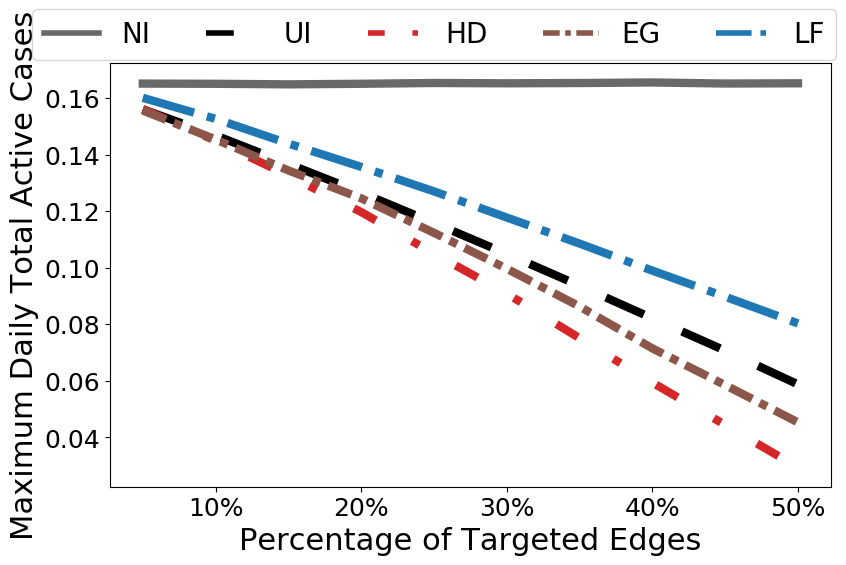

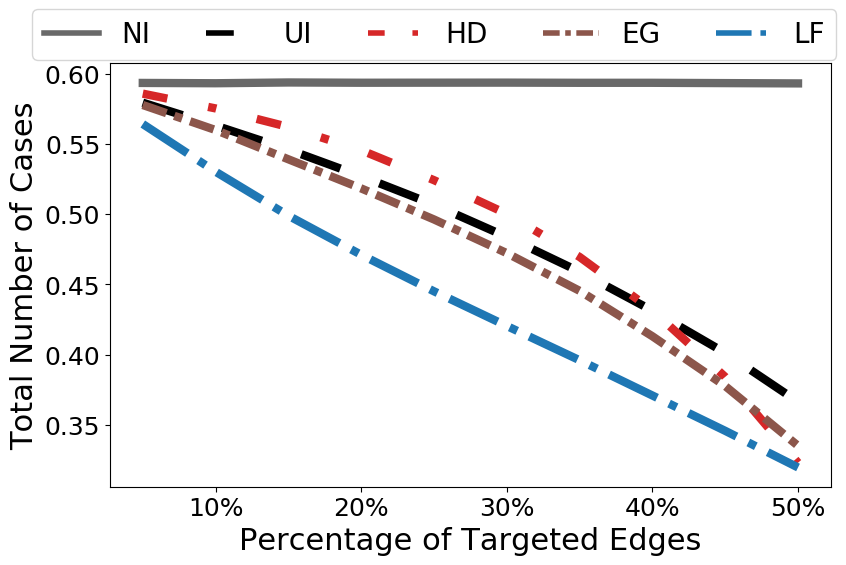

In [29]:
maxCases_ni_mean = vec(mean(maxCases_ni, dims=1))./n;
maxCases_ui_mean = vec(mean(maxCases_ui, dims=1))./n;
maxCases_hd_mean = vec(mean(maxCases_hd, dims=1))./n;
maxCases_eg_mean = vec(mean(maxCases_eg, dims=1))./n;
maxCases_lf_mean = vec(mean(maxCases_lf, dims=1))./n;
totalCases_ni_mean = vec(mean(totalCases_ni, dims=1))./n;
totalCases_ui_mean = vec(mean(totalCases_ui, dims=1))./n;
totalCases_hd_mean = vec(mean(totalCases_hd, dims=1))./n;
totalCases_eg_mean = vec(mean(totalCases_eg, dims=1))./n;
totalCases_lf_mean = vec(mean(totalCases_lf, dims=1))./n;

plt.figure(figsize=(9.3,5.5))
plt.plot(target_perc, maxCases_ni_mean, label="NI", linestyle="-", color="dimgray", linewidth=6)
plt.plot(target_perc, maxCases_ui_mean, label="UI", linestyle=(0,(5,5)), color="k", linewidth=6)
plt.plot(target_perc, maxCases_hd_mean, label="HD", linestyle=(0,(3,5,1,5)), color="tab:red", linewidth=6)
plt.plot(target_perc, maxCases_eg_mean, label="EG", linestyle=(0,(3,1,1,1)), color="tab:brown", linewidth=6)
plt.plot(target_perc, maxCases_lf_mean, label="LF", linestyle="dashdot", color="tab:blue", linewidth=6)
leg = plt.legend(fontsize=20, bbox_to_anchor=(.45, 1.16), ncol=5, loc="upper center", handlelength=2)
for i in leg.legendHandles
    i.set_linewidth(4)
end
plt.xticks((.1, .2, .3, .4, .5), ("10%", "20%", "30%", "40%", "50%"), color="k", size=18)
plt.yticks(size=18)
plt.xlabel("Percentage of Targeted Edges", fontsize=22)
plt.ylabel("Maximum Daily Total Active Cases",fontsize=22)
plt.savefig("portland_epipeak_randinit_R015_delay10.png", bbox_inches="tight", format="png", dpi=400)
plt.show()

plt.figure(figsize=(9.3,5.5))
plt.plot(target_perc, totalCases_ni_mean, label="NI", linestyle="-", color="dimgray", linewidth=6)
plt.plot(target_perc, totalCases_ui_mean, label="UI", linestyle=(0,(5,5)), color="k", linewidth=6)
plt.plot(target_perc, totalCases_hd_mean, label="HD", linestyle=(0,(3,5,1,5)), color="tab:red", linewidth=6)
plt.plot(target_perc, totalCases_eg_mean, label="EG", linestyle=(0,(3,1,1,1)), color="tab:brown", linewidth=6)
plt.plot(target_perc, totalCases_lf_mean, label="LF", linestyle="dashdot", color="tab:blue", linewidth=6)
leg = plt.legend(fontsize=20, bbox_to_anchor=(.45, 1.16), ncol=5, loc="upper center", handlelength=2)
for i in leg.legendHandles
    i.set_linewidth(4)
end
plt.xticks((.1, .2, .3, .4, .5), ("10%", "20%", "30%", "40%", "50%"), color="k", size=18)
plt.yticks(size=18)
plt.xlabel("Percentage of Targeted Edges", fontsize=22)
plt.ylabel("Total Number of Cases",fontsize=22)
plt.savefig("portland_episize_randinit_R015_delay10.png", bbox_inches="tight", format="png", dpi=400)
plt.show()

## Scenario 3: $\beta$ is set to correspond to $R_0 = 3.5$

In [46]:
# Verify that beta is set appropriately
t_end = 50
_, sum_S, sum_E, sum_I, sum_R = Main.agentSEIR(ll, days=t_end, beta=0.26)
println("This should be around 0.966: ", sum_R[t_end+1]/n)

This should be around 0.966: 0.9658534774052208


In [47]:
perc = .25;
reduced_weight = .1;

In [48]:
lw_ui = [ones(length(arr)).*(1.0-(1.0-reduced_weight)*perc) for arr in ll];
lw_hd = get_list_of_weights_degree_dist(ll, edge_to_loc, perc, weight=reduced_weight);
lw_eg = get_list_of_weights_node_centrality(ll, eg, m, edge_to_loc, perc, weight=reduced_weight);
lw_lf = get_list_of_weights_sorted_edges(ll, sorted_edges, edge_to_loc, perc, weight=reduced_weight);

#### Predicted epidemic curves: random initialization, no delay, 25% intervention

In [49]:
t_end = 50

init_rand_infectious = rand(1:n, Int(ceil(0.001*n)))

_, sum_S_ni, sum_E_ni, sum_I_ni, sum_R_ni = agentSEIR(ll, days=t_end, beta=0.26, rand_init=false, init_infectious_nodes=init_rand_infectious);
_, sum_S_ui, sum_E_ui, sum_I_ui, sum_R_ui = agentSEIR(ll, days=t_end, beta=0.26, weighted=true, lw=lw_ui, rand_init=false, init_infectious_nodes=init_rand_infectious);
_, sum_S_hd, sum_E_hd, sum_I_hd, sum_R_hd = agentSEIR(ll, days=t_end, beta=0.26, weighted=true, lw=lw_hd, rand_init=false, init_infectious_nodes=init_rand_infectious);
_, sum_S_eg, sum_E_eg, sum_I_eg, sum_R_eg = agentSEIR(ll, days=t_end, beta=0.26, weighted=true, lw=lw_eg, rand_init=false, init_infectious_nodes=init_rand_infectious);
_, sum_S_lf, sum_E_lf, sum_I_lf, sum_R_lf = agentSEIR(ll, days=t_end, beta=0.26, weighted=true, lw=lw_lf, rand_init=false, init_infectious_nodes=init_rand_infectious);

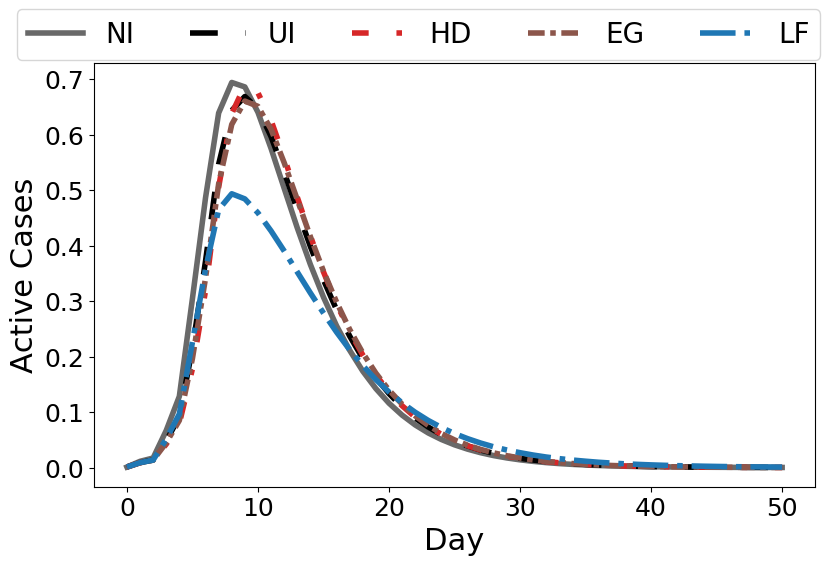

In [50]:
t_int = [i for i in 0:t_end]

plt.figure(figsize=(9.3,5.5))
plt.plot(t_int, (sum_E_ni+sum_I_ni)/n, label="NI", linestyle="-", color="dimgray", linewidth=4)
plt.plot(t_int, (sum_E_ui+sum_I_ui)/n, label="UI", linestyle=(0,(5,5)), color="k", linewidth=4)
plt.plot(t_int, (sum_E_hd+sum_I_hd)/n, label="HD", linestyle=(0,(3,5,1,5)), color="tab:red", linewidth=4, alpha=1)
plt.plot(t_int, (sum_E_eg+sum_I_eg)/n, label="EG", linestyle=(0,(3,1,1,1)), color="tab:brown", linewidth=4, alpha=1)
plt.plot(t_int, (sum_E_lf+sum_I_lf)/n, label="LF", linestyle="dashdot", color="tab:blue", linewidth=4, alpha=1)
leg = plt.legend(fontsize=20, bbox_to_anchor=(.45, 1.16), ncol=5, loc="upper center", handlelength=2)
for i in leg.legendHandles
    i.set_linewidth(4)
end
plt.xticks(size=18)
plt.yticks(size=18)
plt.xlabel("Day", fontsize=22)
plt.ylabel("Active Cases", fontsize=22)
plt.savefig("portland_curves_randinit_R035.png", bbox_inches="tight", format="png", dpi=400)
plt.show()

#### Predicted epidemic curves: random initialization, delay = 10 days, 25% intervention

In [51]:
t_end = 50
t_delay = 5
t_con = t_end - t_delay

init_state, sum_S, sum_E, sum_I, sum_R = Main.agentSEIR(ll, days=t_delay, beta=0.26);
_, _, sum_E_ni, sum_I_ni, sum_R_ni = Main.agentSEIR(ll, days=t_con, beta=0.26, rand_init=false, init_state=init_state);
_, _, sum_E_ui, sum_I_ui, sum_R_ui = Main.agentSEIR(ll, days=t_con, beta=0.26, weighted=true, lw=lw_ui, rand_init=false, init_state=init_state);
_, _, sum_E_hd, sum_I_hd, sum_R_hd = Main.agentSEIR(ll, days=t_con, beta=0.26, weighted=true, lw=lw_hd, rand_init=false, init_state=init_state);
_, _, sum_E_eg, sum_I_eg, sum_R_eg = Main.agentSEIR(ll, days=t_con, beta=0.26, weighted=true, lw=lw_eg, rand_init=false, init_state=init_state);
_, _, sum_E_lf, sum_I_lf, sum_R_lf = Main.agentSEIR(ll, days=t_con, beta=0.26, weighted=true, lw=lw_lf, rand_init=false, init_state=init_state);

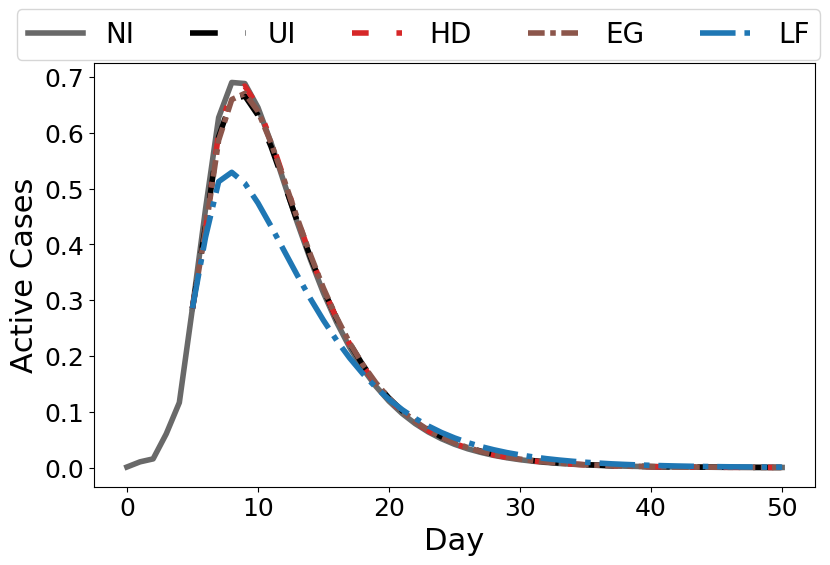

In [52]:
t_ini = [i for i in 0:t_delay]
t_int = [i for i in t_delay:t_end]

plt.figure(figsize=(9.3,5.5))
plt.plot(t_ini, (sum_E+sum_I)/n, linestyle="-", color="dimgray", linewidth=4)
plt.plot(t_int, (sum_E_ni+sum_I_ni)/n, label="NI", linestyle="-", color="dimgray", linewidth=4)
plt.plot(t_int, (sum_E_ui+sum_I_ui)/n, label="UI", linestyle=(0,(5,5)), color="k", linewidth=4)
plt.plot(t_int, (sum_E_hd+sum_I_hd)/n, label="HD", linestyle=(0,(3,5,1,5)), color="tab:red", linewidth=4, alpha=1)
plt.plot(t_int, (sum_E_eg+sum_I_eg)/n, label="EG", linestyle=(0,(3,1,1,1)), color="tab:brown", linewidth=4, alpha=1)
plt.plot(t_int, (sum_E_lf+sum_I_lf)/n, label="LF", linestyle="dashdot", color="tab:blue", linewidth=4, alpha=1)
leg = plt.legend(fontsize=20, bbox_to_anchor=(.45, 1.16), ncol=5, loc="upper center", handlelength=2)
for i in leg.legendHandles
    i.set_linewidth(4)
end
plt.xticks(size=18)
plt.yticks(size=18)
plt.xlabel("Day", fontsize=22)
plt.ylabel("Active Cases", fontsize=22)
plt.savefig("portland_curves_randinit_R035_delay5.png", bbox_inches="tight", format="png", dpi=400)
plt.show()

### Simulation for interventions that start on day 0

In [53]:
reduced_weight = .1;
t_end = 50;
target_perc = Float64[5.0e-2,.1,.15,.2,.25,.3,.35,.4,.45,.5];

num_scenarios = length(target_perc);
num_trials = 5;

maxCases_ni = zeros(Int, (num_trials,num_scenarios));
maxCases_ui = zeros(Int, (num_trials,num_scenarios));
maxCases_hd = zeros(Int, (num_trials,num_scenarios));
maxCases_eg = zeros(Int, (num_trials,num_scenarios));
maxCases_lf = zeros(Int, (num_trials,num_scenarios));
totalCases_ni = zeros(Int, (num_trials,num_scenarios));
totalCases_ui = zeros(Int, (num_trials,num_scenarios));
totalCases_hd = zeros(Int, (num_trials,num_scenarios));
totalCases_eg = zeros(Int, (num_trials,num_scenarios));
totalCases_lf = zeros(Int, (num_trials,num_scenarios));

for k in 1:num_scenarios
    
    perc = target_perc[k];
    
    lw_ui = [ones(length(arr)).*(1.0-(1.0-reduced_weight)*perc) for arr in ll];
    lw_hd = get_list_of_weights_degree_dist(ll, edge_to_loc, perc, weight=reduced_weight);
    lw_eg = get_list_of_weights_node_centrality(ll, eg, m, edge_to_loc, perc, weight=reduced_weight);
    lw_lf = get_list_of_weights_sorted_edges(ll, sorted_edges, edge_to_loc, perc, weight=reduced_weight);
    
    for trial in 1:num_trials
        
        @printf("\rperc %.2f \ttrial %d of %d ", perc, trial, num_trials)
        
        init_rand_infectious = rand(1:n, Int(ceil(0.001*n)))

        _, sum_S_ni, sum_E_ni, sum_I_ni, sum_R_ni = agentSEIR(ll, days=t_end, beta=0.26, rand_init=false, init_infectious_nodes=init_rand_infectious);
        _, sum_S_ui, sum_E_ui, sum_I_ui, sum_R_ui = agentSEIR(ll, days=t_end, beta=0.26, weighted=true, lw=lw_ui, rand_init=false, init_infectious_nodes=init_rand_infectious);
        _, sum_S_hd, sum_E_hd, sum_I_hd, sum_R_hd = agentSEIR(ll, days=t_end, beta=0.26, weighted=true, lw=lw_hd, rand_init=false, init_infectious_nodes=init_rand_infectious);
        _, sum_S_eg, sum_E_eg, sum_I_eg, sum_R_eg = agentSEIR(ll, days=t_end, beta=0.26, weighted=true, lw=lw_eg, rand_init=false, init_infectious_nodes=init_rand_infectious);
        _, sum_S_lf, sum_E_lf, sum_I_lf, sum_R_lf = agentSEIR(ll, days=t_end, beta=0.26, weighted=true, lw=lw_lf, rand_init=false, init_infectious_nodes=init_rand_infectious);
        
        maxCases_ni[trial,k] = maximum(sum_E_ni + sum_I_ni)
        maxCases_ui[trial,k] = maximum(sum_E_ui + sum_I_ui)
        maxCases_hd[trial,k] = maximum(sum_E_hd + sum_I_hd)
        maxCases_eg[trial,k] = maximum(sum_E_eg + sum_I_eg)
        maxCases_lf[trial,k] = maximum(sum_E_lf + sum_I_lf)   
        totalCases_ni[trial,k] = sum_R_ni[t_end+1]
        totalCases_ui[trial,k] = sum_R_ui[t_end+1]
        totalCases_hd[trial,k] = sum_R_hd[t_end+1]
        totalCases_eg[trial,k] = sum_R_eg[t_end+1]
        totalCases_lf[trial,k] = sum_R_lf[t_end+1]
    end
end

perc 0.50 	trial 5 of 5 0.15 	trial 2 of 5 0.15 	trial 4 of 5 0.20 	trial 1 of 5 0.20 	trial 2 of 5 0.20 	trial 3 of 5 0.20 	trial 4 of 5 0.20 	trial 5 of 5 0.25 	trial 1 of 5 0.25 	trial 3 of 5 0.25 	trial 5 of 5 0.35 	trial 2 of 5 0.35 	trial 4 of 5 0.40 	trial 1 of 5 0.40 	trial 2 of 5 0.40 	trial 3 of 5 0.40 	trial 4 of 5 0.40 	trial 5 of 5 0.45 	trial 1 of 5 0.45 	trial 3 of 5 0.45 	trial 5 of 5 

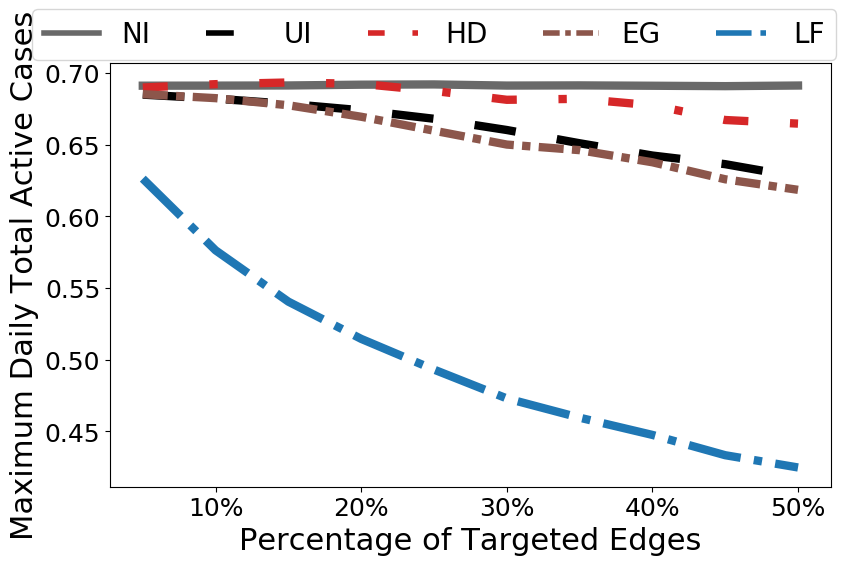

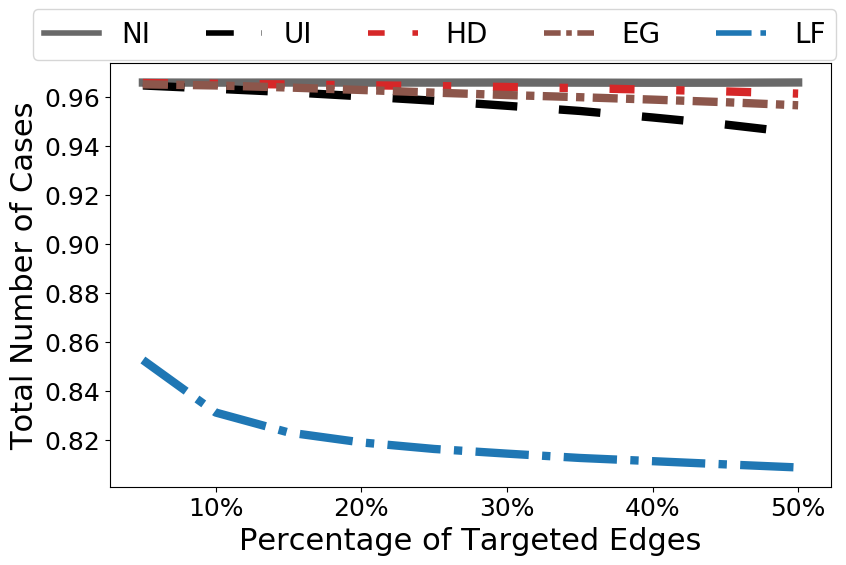

In [54]:
maxCases_ni_mean = vec(mean(maxCases_ni, dims=1))./n;
maxCases_ui_mean = vec(mean(maxCases_ui, dims=1))./n;
maxCases_hd_mean = vec(mean(maxCases_hd, dims=1))./n;
maxCases_eg_mean = vec(mean(maxCases_eg, dims=1))./n;
maxCases_lf_mean = vec(mean(maxCases_lf, dims=1))./n;
totalCases_ni_mean = vec(mean(totalCases_ni, dims=1))./n;
totalCases_ui_mean = vec(mean(totalCases_ui, dims=1))./n;
totalCases_hd_mean = vec(mean(totalCases_hd, dims=1))./n;
totalCases_eg_mean = vec(mean(totalCases_eg, dims=1))./n;
totalCases_lf_mean = vec(mean(totalCases_lf, dims=1))./n;

plt.figure(figsize=(9.3,5.5))
plt.plot(target_perc, maxCases_ni_mean, label="NI", linestyle="-", color="dimgray", linewidth=6)
plt.plot(target_perc, maxCases_ui_mean, label="UI", linestyle=(0,(5,5)), color="k", linewidth=6)
plt.plot(target_perc, maxCases_hd_mean, label="HD", linestyle=(0,(3,5,1,5)), color="tab:red", linewidth=6)
plt.plot(target_perc, maxCases_eg_mean, label="EG", linestyle=(0,(3,1,1,1)), color="tab:brown", linewidth=6)
plt.plot(target_perc, maxCases_lf_mean, label="LF", linestyle="dashdot", color="tab:blue", linewidth=6)
leg = plt.legend(fontsize=20, bbox_to_anchor=(.45, 1.16), ncol=5, loc="upper center", handlelength=2)
for i in leg.legendHandles
    i.set_linewidth(4)
end
plt.xticks((.1, .2, .3, .4, .5), ("10%", "20%", "30%", "40%", "50%"), color="k", size=18)
plt.yticks(size=18)
plt.xlabel("Percentage of Targeted Edges", fontsize=22)
plt.ylabel("Maximum Daily Total Active Cases",fontsize=22)
plt.savefig("portland_epipeak_randinit_R035.png", bbox_inches="tight", format="png", dpi=400)
plt.show()

plt.figure(figsize=(9.3,5.5))
plt.plot(target_perc, totalCases_ni_mean, label="NI", linestyle="-", color="dimgray", linewidth=6)
plt.plot(target_perc, totalCases_ui_mean, label="UI", linestyle=(0,(5,5)), color="k", linewidth=6)
plt.plot(target_perc, totalCases_hd_mean, label="HD", linestyle=(0,(3,5,1,5)), color="tab:red", linewidth=6)
plt.plot(target_perc, totalCases_eg_mean, label="EG", linestyle=(0,(3,1,1,1)), color="tab:brown", linewidth=6)
plt.plot(target_perc, totalCases_lf_mean, label="LF", linestyle="dashdot", color="tab:blue", linewidth=6)
leg = plt.legend(fontsize=20, bbox_to_anchor=(.45, 1.16), ncol=5, loc="upper center", handlelength=2)
for i in leg.legendHandles
    i.set_linewidth(4)
end
plt.xticks((.1, .2, .3, .4, .5), ("10%", "20%", "30%", "40%", "50%"), color="k", size=18)
plt.yticks(size=18)
plt.xlabel("Percentage of Targeted Edges", fontsize=22)
plt.ylabel("Total Number of Cases",fontsize=22)
plt.savefig("portland_episize_randinit_R035.png", bbox_inches="tight", format="png", dpi=400)
plt.show()

### Simulation for interventions that start on day 5

In [55]:
reduced_weight = .1;
target_perc = Float64[5.0e-2,.1,.15,.2,.25,.3,.35,.4,.45,.5];
t_end = 50
t_delay = 5
t_con = t_end - t_delay

num_scenarios = length(target_perc);
num_trials = 5;

maxCases_ni = zeros(Int, (num_trials,num_scenarios));
maxCases_ui = zeros(Int, (num_trials,num_scenarios));
maxCases_hd = zeros(Int, (num_trials,num_scenarios));
maxCases_eg = zeros(Int, (num_trials,num_scenarios));
maxCases_lf = zeros(Int, (num_trials,num_scenarios));
totalCases_ni = zeros(Int, (num_trials,num_scenarios));
totalCases_ui = zeros(Int, (num_trials,num_scenarios));
totalCases_hd = zeros(Int, (num_trials,num_scenarios));
totalCases_eg = zeros(Int, (num_trials,num_scenarios));
totalCases_lf = zeros(Int, (num_trials,num_scenarios));

for k in 1:num_scenarios
    
    perc = target_perc[k];
    
    lw_ui = [ones(length(arr)).*(1.0-(1.0-reduced_weight)*perc) for arr in ll];
    lw_hd = get_list_of_weights_degree_dist(ll, edge_to_loc, perc, weight=reduced_weight);
    lw_eg = get_list_of_weights_node_centrality(ll, eg, m, edge_to_loc, perc, weight=reduced_weight);
    lw_lf = get_list_of_weights_sorted_edges(ll, sorted_edges, edge_to_loc, perc, weight=reduced_weight);
    
    for trial in 1:num_trials
        
        @printf("\rperc %.2f \ttrial %d of %d ", perc, trial, num_trials)
        
        init_rand_infectious = rand(1:n, Int(ceil(0.001*n)))

        init_state, sum_S, sum_E, sum_I, sum_R = Main.agentSEIR(ll, days=t_delay, beta=0.26);
        _, _, sum_E_ni, sum_I_ni, sum_R_ni = Main.agentSEIR(ll, days=t_con, beta=0.26, rand_init=false, init_state=init_state);
        _, _, sum_E_ui, sum_I_ui, sum_R_ui = Main.agentSEIR(ll, days=t_con, beta=0.26, weighted=true, lw=lw_ui, rand_init=false, init_state=init_state);
        _, _, sum_E_hd, sum_I_hd, sum_R_hd = Main.agentSEIR(ll, days=t_con, beta=0.26, weighted=true, lw=lw_hd, rand_init=false, init_state=init_state);
        _, _, sum_E_eg, sum_I_eg, sum_R_eg = Main.agentSEIR(ll, days=t_con, beta=0.26, weighted=true, lw=lw_eg, rand_init=false, init_state=init_state);
        _, _, sum_E_lf, sum_I_lf, sum_R_lf = Main.agentSEIR(ll, days=t_con, beta=0.26, weighted=true, lw=lw_lf, rand_init=false, init_state=init_state);
        
        maxCases_ni[trial,k] = maximum(sum_E_ni + sum_I_ni)
        maxCases_ui[trial,k] = maximum(sum_E_ui + sum_I_ui)
        maxCases_hd[trial,k] = maximum(sum_E_hd + sum_I_hd)
        maxCases_eg[trial,k] = maximum(sum_E_eg + sum_I_eg)
        maxCases_lf[trial,k] = maximum(sum_E_lf + sum_I_lf)   
        totalCases_ni[trial,k] = sum_R_ni[t_con+1]
        totalCases_ui[trial,k] = sum_R_ui[t_con+1]
        totalCases_hd[trial,k] = sum_R_hd[t_con+1]
        totalCases_eg[trial,k] = sum_R_eg[t_con+1]
        totalCases_lf[trial,k] = sum_R_lf[t_con+1]
    end
end

perc 0.50 	trial 5 of 5 0.15 	trial 2 of 5 0.15 	trial 4 of 5 0.20 	trial 1 of 5 0.20 	trial 2 of 5 0.20 	trial 3 of 5 0.20 	trial 4 of 5 0.20 	trial 5 of 5 0.25 	trial 1 of 5 0.25 	trial 3 of 5 0.25 	trial 5 of 5 0.35 	trial 2 of 5 0.35 	trial 4 of 5 0.40 	trial 1 of 5 0.40 	trial 2 of 5 0.40 	trial 3 of 5 0.40 	trial 4 of 5 0.40 	trial 5 of 5 0.45 	trial 1 of 5 0.45 	trial 3 of 5 0.45 	trial 5 of 5 

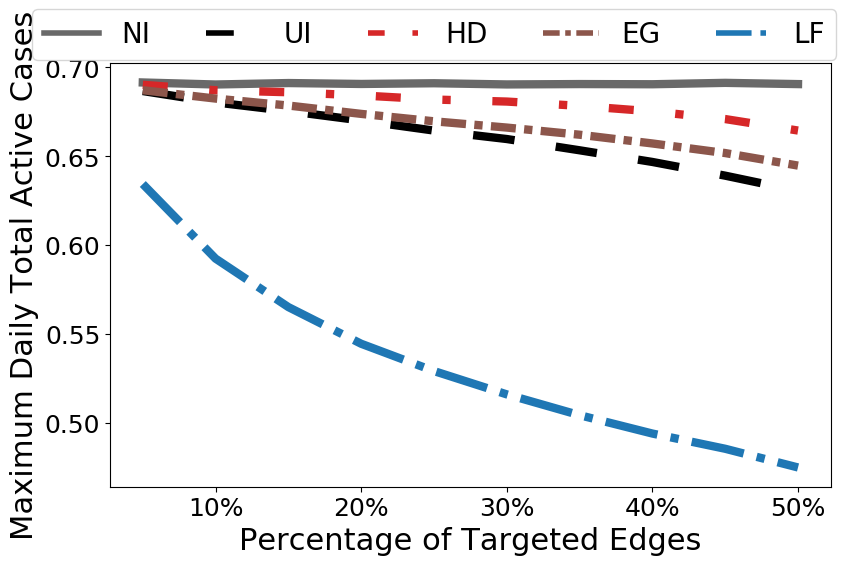

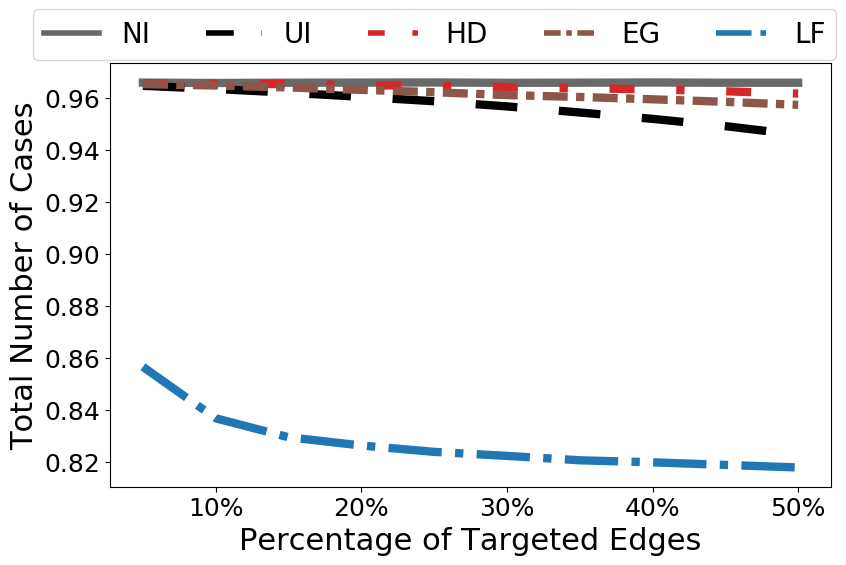

In [56]:
maxCases_ni_mean = vec(mean(maxCases_ni, dims=1))./n;
maxCases_ui_mean = vec(mean(maxCases_ui, dims=1))./n;
maxCases_hd_mean = vec(mean(maxCases_hd, dims=1))./n;
maxCases_eg_mean = vec(mean(maxCases_eg, dims=1))./n;
maxCases_lf_mean = vec(mean(maxCases_lf, dims=1))./n;
totalCases_ni_mean = vec(mean(totalCases_ni, dims=1))./n;
totalCases_ui_mean = vec(mean(totalCases_ui, dims=1))./n;
totalCases_hd_mean = vec(mean(totalCases_hd, dims=1))./n;
totalCases_eg_mean = vec(mean(totalCases_eg, dims=1))./n;
totalCases_lf_mean = vec(mean(totalCases_lf, dims=1))./n;

plt.figure(figsize=(9.3,5.5))
plt.plot(target_perc, maxCases_ni_mean, label="NI", linestyle="-", color="dimgray", linewidth=6)
plt.plot(target_perc, maxCases_ui_mean, label="UI", linestyle=(0,(5,5)), color="k", linewidth=6)
plt.plot(target_perc, maxCases_hd_mean, label="HD", linestyle=(0,(3,5,1,5)), color="tab:red", linewidth=6)
plt.plot(target_perc, maxCases_eg_mean, label="EG", linestyle=(0,(3,1,1,1)), color="tab:brown", linewidth=6)
plt.plot(target_perc, maxCases_lf_mean, label="LF", linestyle="dashdot", color="tab:blue", linewidth=6)
leg = plt.legend(fontsize=20, bbox_to_anchor=(.45, 1.16), ncol=5, loc="upper center", handlelength=2)
for i in leg.legendHandles
    i.set_linewidth(4)
end
plt.xticks((.1, .2, .3, .4, .5), ("10%", "20%", "30%", "40%", "50%"), color="k", size=18)
plt.yticks(size=18)
plt.xlabel("Percentage of Targeted Edges", fontsize=22)
plt.ylabel("Maximum Daily Total Active Cases",fontsize=22)
plt.savefig("portland_epipeak_randinit_R035_delay5.png", bbox_inches="tight", format="png", dpi=400)
plt.show()

plt.figure(figsize=(9.3,5.5))
plt.plot(target_perc, totalCases_ni_mean, label="NI", linestyle="-", color="dimgray", linewidth=6)
plt.plot(target_perc, totalCases_ui_mean, label="UI", linestyle=(0,(5,5)), color="k", linewidth=6)
plt.plot(target_perc, totalCases_hd_mean, label="HD", linestyle=(0,(3,5,1,5)), color="tab:red", linewidth=6)
plt.plot(target_perc, totalCases_eg_mean, label="EG", linestyle=(0,(3,1,1,1)), color="tab:brown", linewidth=6)
plt.plot(target_perc, totalCases_lf_mean, label="LF", linestyle="dashdot", color="tab:blue", linewidth=6)
leg = plt.legend(fontsize=20, bbox_to_anchor=(.45, 1.16), ncol=5, loc="upper center", handlelength=2)
for i in leg.legendHandles
    i.set_linewidth(4)
end
plt.xticks((.1, .2, .3, .4, .5), ("10%", "20%", "30%", "40%", "50%"), color="k", size=18)
plt.yticks(size=18)
plt.xlabel("Percentage of Targeted Edges", fontsize=22)
plt.ylabel("Total Number of Cases",fontsize=22)
plt.savefig("portland_episize_randinit_R035_delay5.png", bbox_inches="tight", format="png", dpi=400)
plt.show()

## Scenario 4: $\beta$ is set to correspond to $R_0 = 4.5$

In [74]:
# Verify that beta is set appropriately
t_end = 50
_, sum_S, sum_E, sum_I, sum_R = Main.agentSEIR(ll, days=t_end, beta=0.8)
println("This should be around 0.99: ", sum_R[t_end+1]/n)

This should be around 0.99: 0.981620932506529


In [69]:
perc = .25;
reduced_weight = .1;

In [70]:
lw_ui = [ones(length(arr)).*(1.0-(1.0-reduced_weight)*perc) for arr in ll];
lw_hd = get_list_of_weights_degree_dist(ll, edge_to_loc, perc, weight=reduced_weight);
lw_eg = get_list_of_weights_node_centrality(ll, eg, m, edge_to_loc, perc, weight=reduced_weight);
lw_lf = get_list_of_weights_sorted_edges(ll, sorted_edges, edge_to_loc, perc, weight=reduced_weight);

#### Predicted epidemic curves: random initialization, no delay, 25% intervention

In [71]:
t_end = 50

init_rand_infectious = rand(1:n, Int(ceil(0.001*n)))

_, sum_S_ni, sum_E_ni, sum_I_ni, sum_R_ni = agentSEIR(ll, days=t_end, beta=0.8, rand_init=false, init_infectious_nodes=init_rand_infectious);
_, sum_S_ui, sum_E_ui, sum_I_ui, sum_R_ui = agentSEIR(ll, days=t_end, beta=0.8, weighted=true, lw=lw_ui, rand_init=false, init_infectious_nodes=init_rand_infectious);
_, sum_S_hd, sum_E_hd, sum_I_hd, sum_R_hd = agentSEIR(ll, days=t_end, beta=0.8, weighted=true, lw=lw_hd, rand_init=false, init_infectious_nodes=init_rand_infectious);
_, sum_S_eg, sum_E_eg, sum_I_eg, sum_R_eg = agentSEIR(ll, days=t_end, beta=0.8, weighted=true, lw=lw_eg, rand_init=false, init_infectious_nodes=init_rand_infectious);
_, sum_S_lf, sum_E_lf, sum_I_lf, sum_R_lf = agentSEIR(ll, days=t_end, beta=0.8, weighted=true, lw=lw_lf, rand_init=false, init_infectious_nodes=init_rand_infectious);

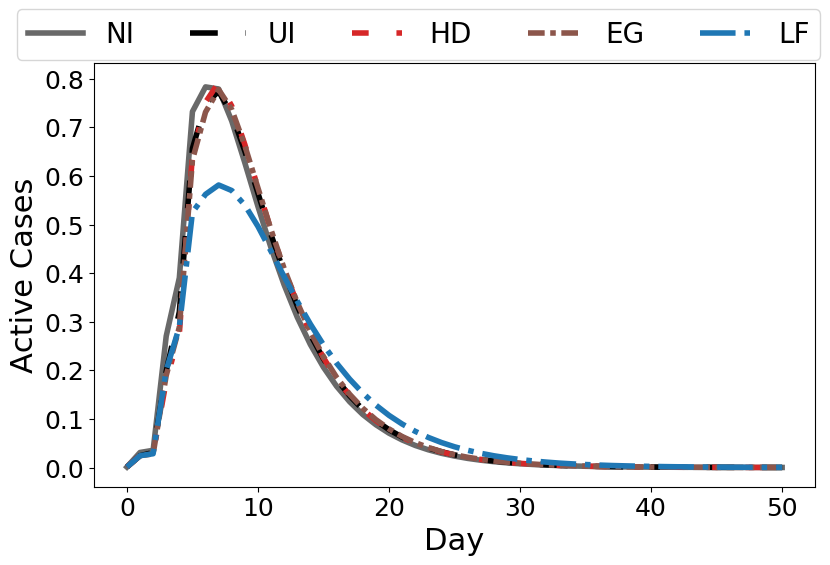

In [72]:
t_int = [i for i in 0:t_end]

plt.figure(figsize=(9.3,5.5))
plt.plot(t_int, (sum_E_ni+sum_I_ni)/n, label="NI", linestyle="-", color="dimgray", linewidth=4)
plt.plot(t_int, (sum_E_ui+sum_I_ui)/n, label="UI", linestyle=(0,(5,5)), color="k", linewidth=4)
plt.plot(t_int, (sum_E_hd+sum_I_hd)/n, label="HD", linestyle=(0,(3,5,1,5)), color="tab:red", linewidth=4, alpha=1)
plt.plot(t_int, (sum_E_eg+sum_I_eg)/n, label="EG", linestyle=(0,(3,1,1,1)), color="tab:brown", linewidth=4, alpha=1)
plt.plot(t_int, (sum_E_lf+sum_I_lf)/n, label="LF", linestyle="dashdot", color="tab:blue", linewidth=4, alpha=1)
leg = plt.legend(fontsize=20, bbox_to_anchor=(.45, 1.16), ncol=5, loc="upper center", handlelength=2)
for i in leg.legendHandles
    i.set_linewidth(4)
end
plt.xticks(size=18)
plt.yticks(size=18)
plt.xlabel("Day", fontsize=22)
plt.ylabel("Active Cases", fontsize=22)
plt.savefig("portland_curves_randinit_R045.png", bbox_inches="tight", format="png", dpi=400)
plt.show()

#### Predicted epidemic curves: random initialization, delay = 10 days, 25% intervention

In [75]:
t_end = 50
t_delay = 5
t_con = t_end - t_delay

init_state, sum_S, sum_E, sum_I, sum_R = Main.agentSEIR(ll, days=t_delay, beta=0.8);
_, _, sum_E_ni, sum_I_ni, sum_R_ni = Main.agentSEIR(ll, days=t_con, beta=0.8, rand_init=false, init_state=init_state);
_, _, sum_E_ui, sum_I_ui, sum_R_ui = Main.agentSEIR(ll, days=t_con, beta=0.8, weighted=true, lw=lw_ui, rand_init=false, init_state=init_state);
_, _, sum_E_hd, sum_I_hd, sum_R_hd = Main.agentSEIR(ll, days=t_con, beta=0.8, weighted=true, lw=lw_hd, rand_init=false, init_state=init_state);
_, _, sum_E_eg, sum_I_eg, sum_R_eg = Main.agentSEIR(ll, days=t_con, beta=0.8, weighted=true, lw=lw_eg, rand_init=false, init_state=init_state);
_, _, sum_E_lf, sum_I_lf, sum_R_lf = Main.agentSEIR(ll, days=t_con, beta=0.8, weighted=true, lw=lw_lf, rand_init=false, init_state=init_state);

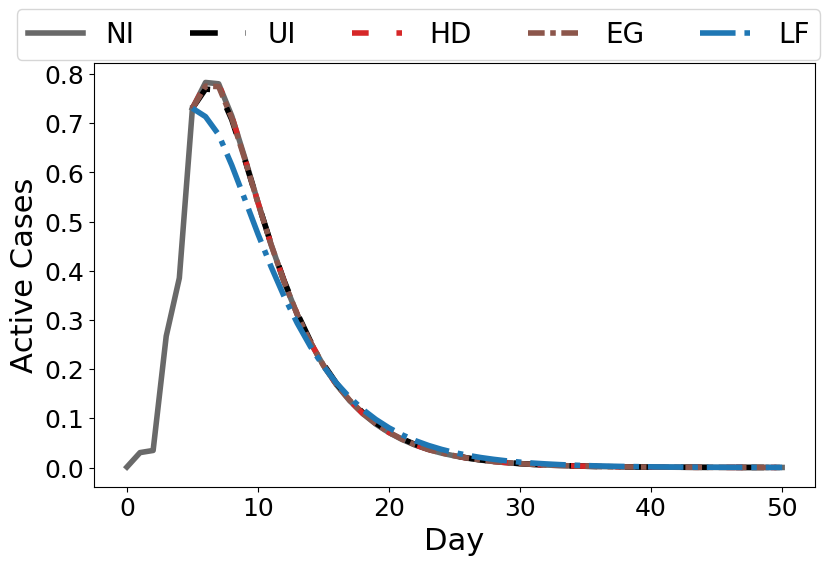

In [76]:
t_ini = [i for i in 0:t_delay]
t_int = [i for i in t_delay:t_end]

plt.figure(figsize=(9.3,5.5))
plt.plot(t_ini, (sum_E+sum_I)/n, linestyle="-", color="dimgray", linewidth=4)
plt.plot(t_int, (sum_E_ni+sum_I_ni)/n, label="NI", linestyle="-", color="dimgray", linewidth=4)
plt.plot(t_int, (sum_E_ui+sum_I_ui)/n, label="UI", linestyle=(0,(5,5)), color="k", linewidth=4)
plt.plot(t_int, (sum_E_hd+sum_I_hd)/n, label="HD", linestyle=(0,(3,5,1,5)), color="tab:red", linewidth=4, alpha=1)
plt.plot(t_int, (sum_E_eg+sum_I_eg)/n, label="EG", linestyle=(0,(3,1,1,1)), color="tab:brown", linewidth=4, alpha=1)
plt.plot(t_int, (sum_E_lf+sum_I_lf)/n, label="LF", linestyle="dashdot", color="tab:blue", linewidth=4, alpha=1)
leg = plt.legend(fontsize=20, bbox_to_anchor=(.45, 1.16), ncol=5, loc="upper center", handlelength=2)
for i in leg.legendHandles
    i.set_linewidth(4)
end
plt.xticks(size=18)
plt.yticks(size=18)
plt.xlabel("Day", fontsize=22)
plt.ylabel("Active Cases", fontsize=22)
plt.savefig("portland_curves_randinit_R045_delay5.png", bbox_inches="tight", format="png", dpi=400)
plt.show()

### Simulation for interventions that start on day 0

In [77]:
reduced_weight = .1;
t_end = 50;
target_perc = Float64[5.0e-2,.1,.15,.2,.25,.3,.35,.4,.45,.5];

num_scenarios = length(target_perc);
num_trials = 5;

maxCases_ni = zeros(Int, (num_trials,num_scenarios));
maxCases_ui = zeros(Int, (num_trials,num_scenarios));
maxCases_hd = zeros(Int, (num_trials,num_scenarios));
maxCases_eg = zeros(Int, (num_trials,num_scenarios));
maxCases_lf = zeros(Int, (num_trials,num_scenarios));
totalCases_ni = zeros(Int, (num_trials,num_scenarios));
totalCases_ui = zeros(Int, (num_trials,num_scenarios));
totalCases_hd = zeros(Int, (num_trials,num_scenarios));
totalCases_eg = zeros(Int, (num_trials,num_scenarios));
totalCases_lf = zeros(Int, (num_trials,num_scenarios));

for k in 1:num_scenarios
    
    perc = target_perc[k];
    
    lw_ui = [ones(length(arr)).*(1.0-(1.0-reduced_weight)*perc) for arr in ll];
    lw_hd = get_list_of_weights_degree_dist(ll, edge_to_loc, perc, weight=reduced_weight);
    lw_eg = get_list_of_weights_node_centrality(ll, eg, m, edge_to_loc, perc, weight=reduced_weight);
    lw_lf = get_list_of_weights_sorted_edges(ll, sorted_edges, edge_to_loc, perc, weight=reduced_weight);
    
    for trial in 1:num_trials
        
        @printf("\rperc %.2f \ttrial %d of %d ", perc, trial, num_trials)
        
        init_rand_infectious = rand(1:n, Int(ceil(0.001*n)))

        _, sum_S_ni, sum_E_ni, sum_I_ni, sum_R_ni = agentSEIR(ll, days=t_end, beta=0.8, rand_init=false, init_infectious_nodes=init_rand_infectious);
        _, sum_S_ui, sum_E_ui, sum_I_ui, sum_R_ui = agentSEIR(ll, days=t_end, beta=0.8, weighted=true, lw=lw_ui, rand_init=false, init_infectious_nodes=init_rand_infectious);
        _, sum_S_hd, sum_E_hd, sum_I_hd, sum_R_hd = agentSEIR(ll, days=t_end, beta=0.8, weighted=true, lw=lw_hd, rand_init=false, init_infectious_nodes=init_rand_infectious);
        _, sum_S_eg, sum_E_eg, sum_I_eg, sum_R_eg = agentSEIR(ll, days=t_end, beta=0.8, weighted=true, lw=lw_eg, rand_init=false, init_infectious_nodes=init_rand_infectious);
        _, sum_S_lf, sum_E_lf, sum_I_lf, sum_R_lf = agentSEIR(ll, days=t_end, beta=0.8, weighted=true, lw=lw_lf, rand_init=false, init_infectious_nodes=init_rand_infectious);
        
        maxCases_ni[trial,k] = maximum(sum_E_ni + sum_I_ni)
        maxCases_ui[trial,k] = maximum(sum_E_ui + sum_I_ui)
        maxCases_hd[trial,k] = maximum(sum_E_hd + sum_I_hd)
        maxCases_eg[trial,k] = maximum(sum_E_eg + sum_I_eg)
        maxCases_lf[trial,k] = maximum(sum_E_lf + sum_I_lf)   
        totalCases_ni[trial,k] = sum_R_ni[t_end+1]
        totalCases_ui[trial,k] = sum_R_ui[t_end+1]
        totalCases_hd[trial,k] = sum_R_hd[t_end+1]
        totalCases_eg[trial,k] = sum_R_eg[t_end+1]
        totalCases_lf[trial,k] = sum_R_lf[t_end+1]
    end
end

perc 0.50 	trial 5 of 5 0.15 	trial 2 of 5 0.15 	trial 4 of 5 0.20 	trial 1 of 5 0.20 	trial 2 of 5 0.20 	trial 3 of 5 0.20 	trial 4 of 5 0.20 	trial 5 of 5 0.25 	trial 1 of 5 0.25 	trial 3 of 5 0.25 	trial 5 of 5 0.35 	trial 2 of 5 0.35 	trial 4 of 5 0.40 	trial 1 of 5 0.40 	trial 2 of 5 0.40 	trial 3 of 5 0.40 	trial 4 of 5 0.40 	trial 5 of 5 0.45 	trial 1 of 5 0.45 	trial 3 of 5 0.45 	trial 5 of 5 

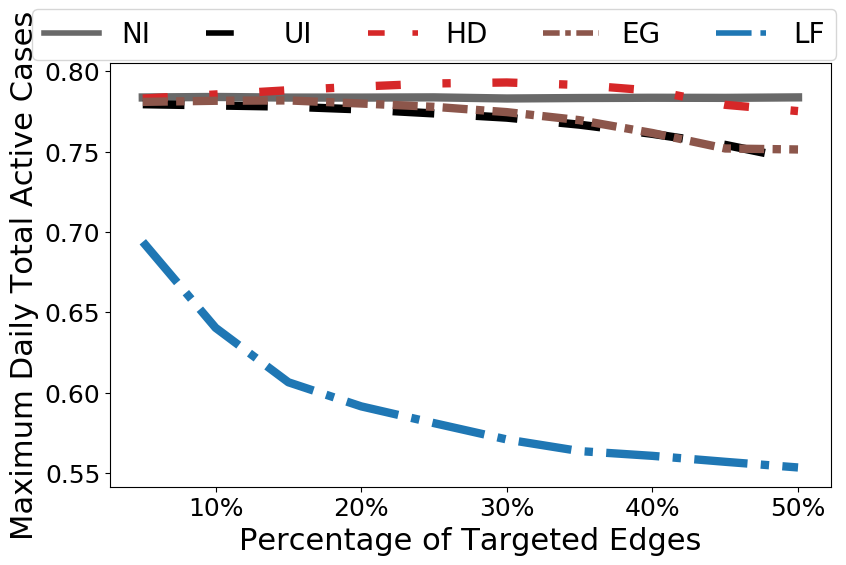

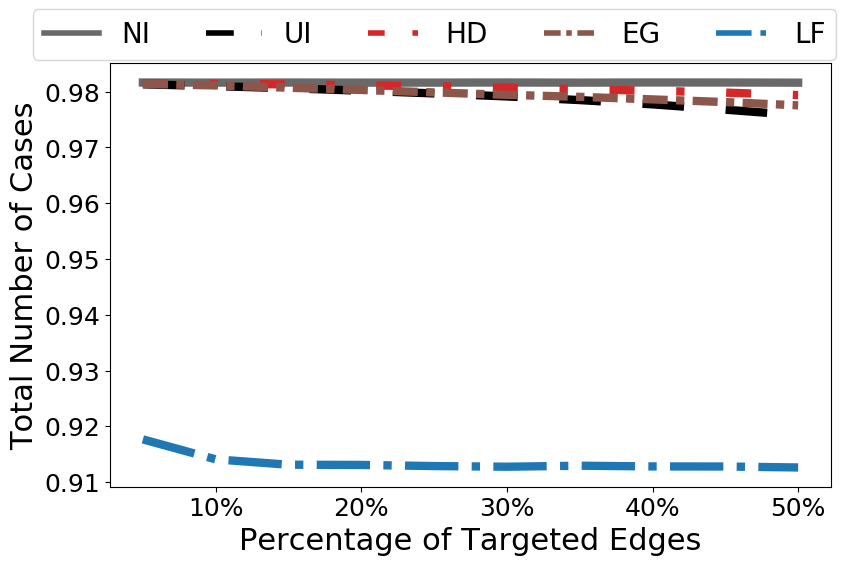

In [78]:
maxCases_ni_mean = vec(mean(maxCases_ni, dims=1))./n;
maxCases_ui_mean = vec(mean(maxCases_ui, dims=1))./n;
maxCases_hd_mean = vec(mean(maxCases_hd, dims=1))./n;
maxCases_eg_mean = vec(mean(maxCases_eg, dims=1))./n;
maxCases_lf_mean = vec(mean(maxCases_lf, dims=1))./n;
totalCases_ni_mean = vec(mean(totalCases_ni, dims=1))./n;
totalCases_ui_mean = vec(mean(totalCases_ui, dims=1))./n;
totalCases_hd_mean = vec(mean(totalCases_hd, dims=1))./n;
totalCases_eg_mean = vec(mean(totalCases_eg, dims=1))./n;
totalCases_lf_mean = vec(mean(totalCases_lf, dims=1))./n;

plt.figure(figsize=(9.3,5.5))
plt.plot(target_perc, maxCases_ni_mean, label="NI", linestyle="-", color="dimgray", linewidth=6)
plt.plot(target_perc, maxCases_ui_mean, label="UI", linestyle=(0,(5,5)), color="k", linewidth=6)
plt.plot(target_perc, maxCases_hd_mean, label="HD", linestyle=(0,(3,5,1,5)), color="tab:red", linewidth=6)
plt.plot(target_perc, maxCases_eg_mean, label="EG", linestyle=(0,(3,1,1,1)), color="tab:brown", linewidth=6)
plt.plot(target_perc, maxCases_lf_mean, label="LF", linestyle="dashdot", color="tab:blue", linewidth=6)
leg = plt.legend(fontsize=20, bbox_to_anchor=(.45, 1.16), ncol=5, loc="upper center", handlelength=2)
for i in leg.legendHandles
    i.set_linewidth(4)
end
plt.xticks((.1, .2, .3, .4, .5), ("10%", "20%", "30%", "40%", "50%"), color="k", size=18)
plt.yticks(size=18)
plt.xlabel("Percentage of Targeted Edges", fontsize=22)
plt.ylabel("Maximum Daily Total Active Cases",fontsize=22)
plt.savefig("portland_epipeak_randinit_R045.png", bbox_inches="tight", format="png", dpi=400)
plt.show()

plt.figure(figsize=(9.3,5.5))
plt.plot(target_perc, totalCases_ni_mean, label="NI", linestyle="-", color="dimgray", linewidth=6)
plt.plot(target_perc, totalCases_ui_mean, label="UI", linestyle=(0,(5,5)), color="k", linewidth=6)
plt.plot(target_perc, totalCases_hd_mean, label="HD", linestyle=(0,(3,5,1,5)), color="tab:red", linewidth=6)
plt.plot(target_perc, totalCases_eg_mean, label="EG", linestyle=(0,(3,1,1,1)), color="tab:brown", linewidth=6)
plt.plot(target_perc, totalCases_lf_mean, label="LF", linestyle="dashdot", color="tab:blue", linewidth=6)
leg = plt.legend(fontsize=20, bbox_to_anchor=(.45, 1.16), ncol=5, loc="upper center", handlelength=2)
for i in leg.legendHandles
    i.set_linewidth(4)
end
plt.xticks((.1, .2, .3, .4, .5), ("10%", "20%", "30%", "40%", "50%"), color="k", size=18)
plt.yticks(size=18)
plt.xlabel("Percentage of Targeted Edges", fontsize=22)
plt.ylabel("Total Number of Cases",fontsize=22)
plt.savefig("portland_episize_randinit_R045.png", bbox_inches="tight", format="png", dpi=400)
plt.show()

### Simulation for interventions that start on day 5

In [79]:
reduced_weight = .1;
target_perc = Float64[5.0e-2,.1,.15,.2,.25,.3,.35,.4,.45,.5];
t_end = 50
t_delay = 5
t_con = t_end - t_delay

num_scenarios = length(target_perc);
num_trials = 5;

maxCases_ni = zeros(Int, (num_trials,num_scenarios));
maxCases_ui = zeros(Int, (num_trials,num_scenarios));
maxCases_hd = zeros(Int, (num_trials,num_scenarios));
maxCases_eg = zeros(Int, (num_trials,num_scenarios));
maxCases_lf = zeros(Int, (num_trials,num_scenarios));
totalCases_ni = zeros(Int, (num_trials,num_scenarios));
totalCases_ui = zeros(Int, (num_trials,num_scenarios));
totalCases_hd = zeros(Int, (num_trials,num_scenarios));
totalCases_eg = zeros(Int, (num_trials,num_scenarios));
totalCases_lf = zeros(Int, (num_trials,num_scenarios));

for k in 1:num_scenarios
    
    perc = target_perc[k];
    
    lw_ui = [ones(length(arr)).*(1.0-(1.0-reduced_weight)*perc) for arr in ll];
    lw_hd = get_list_of_weights_degree_dist(ll, edge_to_loc, perc, weight=reduced_weight);
    lw_eg = get_list_of_weights_node_centrality(ll, eg, m, edge_to_loc, perc, weight=reduced_weight);
    lw_lf = get_list_of_weights_sorted_edges(ll, sorted_edges, edge_to_loc, perc, weight=reduced_weight);
    
    for trial in 1:num_trials
        
        @printf("\rperc %.2f \ttrial %d of %d ", perc, trial, num_trials)
        
        init_rand_infectious = rand(1:n, Int(ceil(0.001*n)))

        init_state, sum_S, sum_E, sum_I, sum_R = Main.agentSEIR(ll, days=t_delay, beta=0.8);
        _, _, sum_E_ni, sum_I_ni, sum_R_ni = Main.agentSEIR(ll, days=t_con, beta=0.8, rand_init=false, init_state=init_state);
        _, _, sum_E_ui, sum_I_ui, sum_R_ui = Main.agentSEIR(ll, days=t_con, beta=0.8, weighted=true, lw=lw_ui, rand_init=false, init_state=init_state);
        _, _, sum_E_hd, sum_I_hd, sum_R_hd = Main.agentSEIR(ll, days=t_con, beta=0.8, weighted=true, lw=lw_hd, rand_init=false, init_state=init_state);
        _, _, sum_E_eg, sum_I_eg, sum_R_eg = Main.agentSEIR(ll, days=t_con, beta=0.8, weighted=true, lw=lw_eg, rand_init=false, init_state=init_state);
        _, _, sum_E_lf, sum_I_lf, sum_R_lf = Main.agentSEIR(ll, days=t_con, beta=0.8, weighted=true, lw=lw_lf, rand_init=false, init_state=init_state);
        
        maxCases_ni[trial,k] = maximum(sum_E_ni + sum_I_ni)
        maxCases_ui[trial,k] = maximum(sum_E_ui + sum_I_ui)
        maxCases_hd[trial,k] = maximum(sum_E_hd + sum_I_hd)
        maxCases_eg[trial,k] = maximum(sum_E_eg + sum_I_eg)
        maxCases_lf[trial,k] = maximum(sum_E_lf + sum_I_lf)   
        totalCases_ni[trial,k] = sum_R_ni[t_con+1]
        totalCases_ui[trial,k] = sum_R_ui[t_con+1]
        totalCases_hd[trial,k] = sum_R_hd[t_con+1]
        totalCases_eg[trial,k] = sum_R_eg[t_con+1]
        totalCases_lf[trial,k] = sum_R_lf[t_con+1]
    end
end

perc 0.50 	trial 5 of 5 0.15 	trial 2 of 5 0.15 	trial 4 of 5 0.20 	trial 1 of 5 0.20 	trial 2 of 5 0.20 	trial 3 of 5 0.20 	trial 4 of 5 0.20 	trial 5 of 5 0.25 	trial 1 of 5 0.25 	trial 3 of 5 0.25 	trial 5 of 5 0.35 	trial 2 of 5 0.35 	trial 4 of 5 0.40 	trial 1 of 5 0.40 	trial 2 of 5 0.40 	trial 3 of 5 0.40 	trial 4 of 5 0.40 	trial 5 of 5 0.45 	trial 1 of 5 0.45 	trial 3 of 5 0.45 	trial 5 of 5 

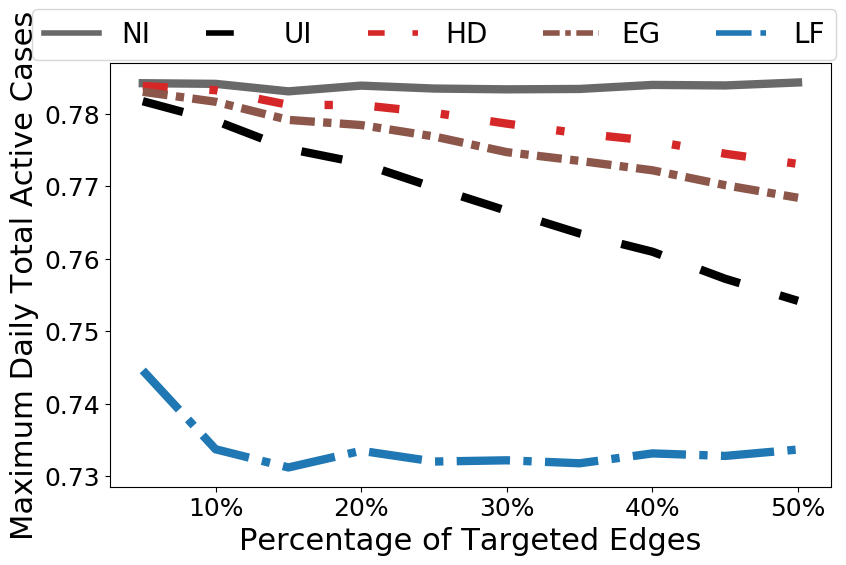

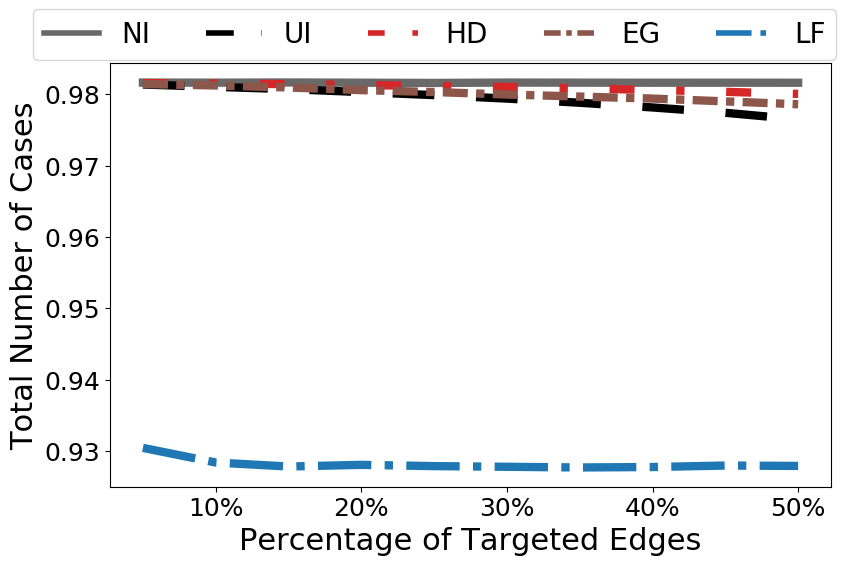

In [80]:
maxCases_ni_mean = vec(mean(maxCases_ni, dims=1))./n;
maxCases_ui_mean = vec(mean(maxCases_ui, dims=1))./n;
maxCases_hd_mean = vec(mean(maxCases_hd, dims=1))./n;
maxCases_eg_mean = vec(mean(maxCases_eg, dims=1))./n;
maxCases_lf_mean = vec(mean(maxCases_lf, dims=1))./n;
totalCases_ni_mean = vec(mean(totalCases_ni, dims=1))./n;
totalCases_ui_mean = vec(mean(totalCases_ui, dims=1))./n;
totalCases_hd_mean = vec(mean(totalCases_hd, dims=1))./n;
totalCases_eg_mean = vec(mean(totalCases_eg, dims=1))./n;
totalCases_lf_mean = vec(mean(totalCases_lf, dims=1))./n;

plt.figure(figsize=(9.3,5.5))
plt.plot(target_perc, maxCases_ni_mean, label="NI", linestyle="-", color="dimgray", linewidth=6)
plt.plot(target_perc, maxCases_ui_mean, label="UI", linestyle=(0,(5,5)), color="k", linewidth=6)
plt.plot(target_perc, maxCases_hd_mean, label="HD", linestyle=(0,(3,5,1,5)), color="tab:red", linewidth=6)
plt.plot(target_perc, maxCases_eg_mean, label="EG", linestyle=(0,(3,1,1,1)), color="tab:brown", linewidth=6)
plt.plot(target_perc, maxCases_lf_mean, label="LF", linestyle="dashdot", color="tab:blue", linewidth=6)
leg = plt.legend(fontsize=20, bbox_to_anchor=(.45, 1.16), ncol=5, loc="upper center", handlelength=2)
for i in leg.legendHandles
    i.set_linewidth(4)
end
plt.xticks((.1, .2, .3, .4, .5), ("10%", "20%", "30%", "40%", "50%"), color="k", size=18)
plt.yticks(size=18)
plt.xlabel("Percentage of Targeted Edges", fontsize=22)
plt.ylabel("Maximum Daily Total Active Cases",fontsize=22)
plt.savefig("portland_epipeak_randinit_R045_delay5.png", bbox_inches="tight", format="png", dpi=400)
plt.show()

plt.figure(figsize=(9.3,5.5))
plt.plot(target_perc, totalCases_ni_mean, label="NI", linestyle="-", color="dimgray", linewidth=6)
plt.plot(target_perc, totalCases_ui_mean, label="UI", linestyle=(0,(5,5)), color="k", linewidth=6)
plt.plot(target_perc, totalCases_hd_mean, label="HD", linestyle=(0,(3,5,1,5)), color="tab:red", linewidth=6)
plt.plot(target_perc, totalCases_eg_mean, label="EG", linestyle=(0,(3,1,1,1)), color="tab:brown", linewidth=6)
plt.plot(target_perc, totalCases_lf_mean, label="LF", linestyle="dashdot", color="tab:blue", linewidth=6)
leg = plt.legend(fontsize=20, bbox_to_anchor=(.45, 1.16), ncol=5, loc="upper center", handlelength=2)
for i in leg.legendHandles
    i.set_linewidth(4)
end
plt.xticks((.1, .2, .3, .4, .5), ("10%", "20%", "30%", "40%", "50%"), color="k", size=18)
plt.yticks(size=18)
plt.xlabel("Percentage of Targeted Edges", fontsize=22)
plt.ylabel("Total Number of Cases",fontsize=22)
plt.savefig("portland_episize_randinit_R045_delay5.png", bbox_inches="tight", format="png", dpi=400)
plt.show()